# Regressão
## dataset: california_housing

In [179]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import math
import random  # Para inicializar pesos aleatórios
import networkx as nx  # Para visualização do grafo da MLP
import matplotlib.pyplot as plt  # Para plotar a estrutura da rede e gráficos
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [180]:
class ActivationFunctions:
    @staticmethod
    def relu(x):
        """
        ReLU (Rectified Linear Unit) function.
        :param x: Single value or list of values.
        :return: max(0, x) for each value.
        """
        if isinstance(x, list):
            return [max(0, value) for value in x]
        return max(0, x)

    @staticmethod
    def relu_derivative(x):
        """
        Derivative of ReLU function.
        :param x: Single value or list of values.
        :return: 1 if x > 0, else 0 for each value.
        """
        if isinstance(x, list):
            return [1 if value > 0 else 0 for value in x]
        return 1 if x > 0 else 0

    @staticmethod
    def linear(x):
        """
        Linear activation function.
        :param x: Single value or list of values.
        :return: x (identity function).
        """
        if isinstance(x, list):
            return x
        return x

    @staticmethod
    def linear_derivative(x):
        """
        Derivative of the linear function.
        :param x: Single value or list of values.
        :return: 1 for any input.
        """
        if isinstance(x, list):
            return [1 for _ in x]
        return 1

    @staticmethod
    def sigmoid(x):
        """
        Sigmoid activation function.
        :param x: Single value or list of values.
        :return: 1 / (1 + exp(-x)) for each value.
        """
        if isinstance(x, list):
            return [1 / (1 + math.exp(-value)) for value in x]
        return 1 / (1 + math.exp(-x))

    @staticmethod
    def sigmoid_derivative(x):
        """
        Derivative of the sigmoid function.
        :param x: Single value or list of values.
        :return: sigmoid(x) * (1 - sigmoid(x)) for each value.
        """
        sigmoid_value = ActivationFunctions.sigmoid(x)
        if isinstance(x, list):
            return [value * (1 - value) for value in sigmoid_value]
        return sigmoid_value * (1 - sigmoid_value)

    @staticmethod
    def softmax(x):
        """
        Softmax activation function.
        :param x: Single value or list of values.
        :return: Probabilities (sum to 1) for each input.
        """
        exps = np.exp(x - np.max(x, axis=-1, keepdims=True))  # Numerical stability
        return exps / np.sum(exps, axis=-1, keepdims=True)

In [181]:
print(ActivationFunctions.relu(-5))  # Saída esperada: 0
print(ActivationFunctions.relu(5))   # Saída esperada: 5
print(ActivationFunctions.relu_derivative(-5))  # Saída esperada: 0
print(ActivationFunctions.relu_derivative(5))   # Saída esperada: 1
print(ActivationFunctions.linear(10))  # Saída esperada: 10
print(ActivationFunctions.linear_derivative(10))  # Saída esperada: 1
print(ActivationFunctions.sigmoid(-5))  # Saída esperada: 0.0066928509242848554
print(ActivationFunctions.sigmoid(5))   # Saída esperada: 0.9933071490757153
print(ActivationFunctions.sigmoid_derivative(-5))  # Saída esperada: 0.006648056288095992
print(ActivationFunctions.sigmoid_derivative(5))   # Saída esperada: 0.006648056288095992

print(ActivationFunctions.relu([-5, 5, 0]))  # Saída esperada: [0, 5, 0]
print(ActivationFunctions.relu_derivative([-5, 5, 0]))  # Saída esperada: [0, 1, 0]
print(ActivationFunctions.linear([10, -10, 0]))  # Saída esperada: [10, -10, 0]
print(ActivationFunctions.linear_derivative([10, -10, 0]))  # Saída esperada: [1, 1, 1]
print(ActivationFunctions.sigmoid([-5, 5, 0]))  # Saída esperada: [0.0066928509242848554, 0.9933071490757153, 0.5]
print(ActivationFunctions.sigmoid_derivative([-5, 5, 0]))  # Saída esperada: [0.006648056288095992, 0.006648056288095992, 0.25]

0
5
0
1
10
1
0.0066928509242848554
0.9933071490757153
0.006648056670790155
0.006648056670790033
[0, 5, 0]
[0, 1, 0]
[10, -10, 0]
[1, 1, 1]
[0.0066928509242848554, 0.9933071490757153, 0.5]
[0.006648056670790155, 0.006648056670790033, 0.25]


In [182]:
class MLP:
    def __init__(self, *layers, learning_rate=0.01, momentum=0.9, random_seed=42):
        """
        Inicializa a estrutura da MLP.

        :param layers: Número de neurônios em cada camada, incluindo entrada, ocultas e saída.
        :param learning_rate: Taxa de aprendizado.
        :param momentum: Fator de momento para a descida do gradiente.
        :param random_seed: Semente para inicialização de pesos.
        """
        self.layers_sizes = layers
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.random_seed = random_seed  # Semente para controle de aleatoriedade
        self.weights = []
        self.biases = []
        self.velocities_weights = []  # Velocidades para os pesos
        self.velocities_biases = []   # Velocidades para os vieses
        self.outputs = []
        self.initialize_network()

    def initialize_network(self):
        """
        Inicializa a rede criando as matrizes de pesos e vetores de bias entre as camadas.
        Também inicializa as velocidades (momentum) como zero.
        """
        np.random.seed(self.random_seed)  # Definir a semente para garantir a consistência

        for i in range(len(self.layers_sizes) - 1):
            input_neurons = self.layers_sizes[i]
            output_neurons = self.layers_sizes[i + 1]
            # Inicializar pesos aleatórios entre -1 e 1 com NumPy
            self.weights.append(np.random.uniform(-1, 1, (input_neurons, output_neurons)))
            # Inicializar biases aleatórios entre -1 e 1 com NumPy
            self.biases.append(np.random.uniform(-1, 1, output_neurons))
            # Inicializar velocidades como zeros
            self.velocities_weights.append(np.zeros((input_neurons, output_neurons)))
            self.velocities_biases.append(np.zeros(output_neurons))

    def calculate_z(self, inputs, weights, biases):
        """
        Calcula Z = W * X + b usando NumPy.
        """
        return np.dot(inputs, weights) + biases

    def forward_propagation(self, inputs):
        """
        Realiza a propagação para frente através da rede.
        """
        self.outputs = [np.array(inputs)]  # Certifique-se de que inputs é um vetor 1D

        current_output = self.outputs[0]
        for i in range(len(self.weights)):
            # Cálculo de Z = W * X + b
            z = self.calculate_z(current_output, self.weights[i], self.biases[i])

            # Ativação para camadas ocultas e saída
            if i < len(self.weights) - 1:  # Camadas ocultas
                current_output = np.maximum(0, z)  # ReLU
            else:  # Camada de saída
                current_output = z  # Linear para regressão

            # Armazenar a saída corretamente
            self.outputs.append(np.array(current_output))  # Certifique-se de que é um array

        return current_output


    def backward_propagation(self, expected_output):
        """
        Realiza a retropropagação do erro e atualiza os pesos e biases com suporte a mini-batches.
        Aplica momento para suavizar e acelerar as atualizações.
        """
        expected_output = np.array(expected_output)
        deltas = [None] * len(self.weights)

        # Cálculo dos deltas para a camada de saída
        errors = expected_output - self.outputs[-1]  # (batch_size, output_size)
        deltas[-1] = errors  # Derivada da função linear é 1

        # Retropropagar para camadas ocultas
        for i in range(len(self.weights) - 2, -1, -1):
            z_derivative = (self.outputs[i + 1] > 0).astype(float)  # Derivada da ReLU
            deltas[i] = np.dot(deltas[i + 1], self.weights[i + 1].T) * z_derivative

        # Atualizar pesos e biases com momento
        for i in range(len(self.weights)):
            grad_weights = np.dot(self.outputs[i].T, deltas[i])  # Gradiente dos pesos
            grad_biases = np.sum(deltas[i], axis=0)  # Gradiente dos vieses

            # Atualizar velocidades com momento
            self.velocities_weights[i] = self.momentum * self.velocities_weights[i] + self.learning_rate * grad_weights
            self.velocities_biases[i] = self.momentum * self.velocities_biases[i] + self.learning_rate * grad_biases

            # Atualizar pesos e vieses usando as velocidades
            self.weights[i] += self.velocities_weights[i]
            self.biases[i] += self.velocities_biases[i]

    def calculate_error(self, expected_output):
        """
        Calcula o erro total da rede (MSE).
        """
        outputs = self.outputs[-1]
        return np.mean((expected_output - outputs) ** 2) / 2

    def train(self, inputs, expected_outputs, epochs=1000, tolerance=1e-5, batch_size=32):
        errors = []
        inputs = np.array(inputs)
        expected_outputs = np.array(expected_outputs)

        for epoch in range(epochs):
            total_error = 0
            
            # Embaralhar os dados no início de cada época
            indices = np.arange(len(inputs))
            np.random.shuffle(indices)
            inputs = inputs[indices]
            expected_outputs = expected_outputs[indices]

            # Processar em mini-batches
            for i in range(0, len(inputs), batch_size):
                batch_inputs = inputs[i:i + batch_size]
                batch_outputs = expected_outputs[i:i + batch_size]

                self.forward_propagation(batch_inputs)  # Propagação para frente em lote
                self.backward_propagation(batch_outputs)  # Retropropagação em lote
                total_error += np.sum((batch_outputs - self.outputs[-1]) ** 2) / 2

            mean_error = total_error / len(inputs)
            errors.append(mean_error)
            
            # Verificar tolerância
            if mean_error < tolerance:
                break

        return errors

    def list_weights(self):
        """Lista todos os pesos da rede, camada por camada."""
        print("Listing all weights in the network:\n")
        for layer_index, layer_weights in enumerate(self.weights):
            print(f"Layer {layer_index + 1} to Layer {layer_index + 2}:")
            for i, weights_from_neuron in enumerate(layer_weights):
                for j, weight in enumerate(weights_from_neuron):
                    print(f"  Weight from Neuron {i} in Layer {layer_index + 1} "
                          f"to Neuron {j} in Layer {layer_index + 2}: {weight:.4f}")
            print("\n")

    def test_model(self, test_inputs, expected_outputs):
        """
        Avalia o modelo nos dados de teste e calcula métricas de desempenho.

        :param test_inputs: Dados de entrada para teste.
        :param expected_outputs: Valores reais esperados para teste.
        :return: Predições, MSE, MAE, R² Score.
        """
        predictions = []
        total_error = 0

        for inp, exp_out in zip(test_inputs, expected_outputs):
            prediction = self.forward_propagation(inp)[0]  # Realiza a predição
            predictions.append(prediction)
            total_error += (exp_out - prediction) ** 2  # Soma do erro quadrático

        # Calcular métricas
        mse = total_error / len(test_inputs)
        mae = np.mean([abs(exp_out - pred) for exp_out, pred in zip(expected_outputs, predictions)])
        r2 = 1 - (total_error / np.sum((expected_outputs - np.mean(expected_outputs)) ** 2))

        return predictions, mse, mae, r2

    def plot_network(self):
        """Plota a estrutura da rede MLP como um grafo e verifica os pesos."""
        total_weights = 0
        for layer_index, layer_weights in enumerate(self.weights):
            print(f"Layer {layer_index + 1} to Layer {layer_index + 2}: {len(layer_weights)} x {len(layer_weights[0])} weights")
            total_weights += len(layer_weights) * len(layer_weights[0])
        print(f"Total Weights: {total_weights}")

        G = nx.DiGraph()  # Grafo direcionado

        node_id = 0
        positions = {}  # Para armazenar as posições (camadas)
        for layer_index, num_neurons in enumerate(self.layers_sizes):
            for neuron in range(num_neurons):
                G.add_node(node_id, subset=layer_index)
                positions[node_id] = layer_index
                node_id += 1

        current_node = 0
        for layer_index, (input_size, output_size) in enumerate(zip(self.layers_sizes[:-1], self.layers_sizes[1:])):
            for i in range(input_size):
                for j in range(output_size):
                    weight = round(self.weights[layer_index][i][j], 2)
                    G.add_edge(current_node + i, current_node + input_size + j, weight=weight)
            current_node += input_size

        pos = nx.multipartite_layout(G, subset_key="subset")

        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=8, font_weight="bold", arrowsize=10)

        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

        plt.title("MLP Structure")
        plt.show()


Layer 1 to Layer 2: 9 x 9 weights
Layer 2 to Layer 3: 9 x 1 weights
Total Weights: 90


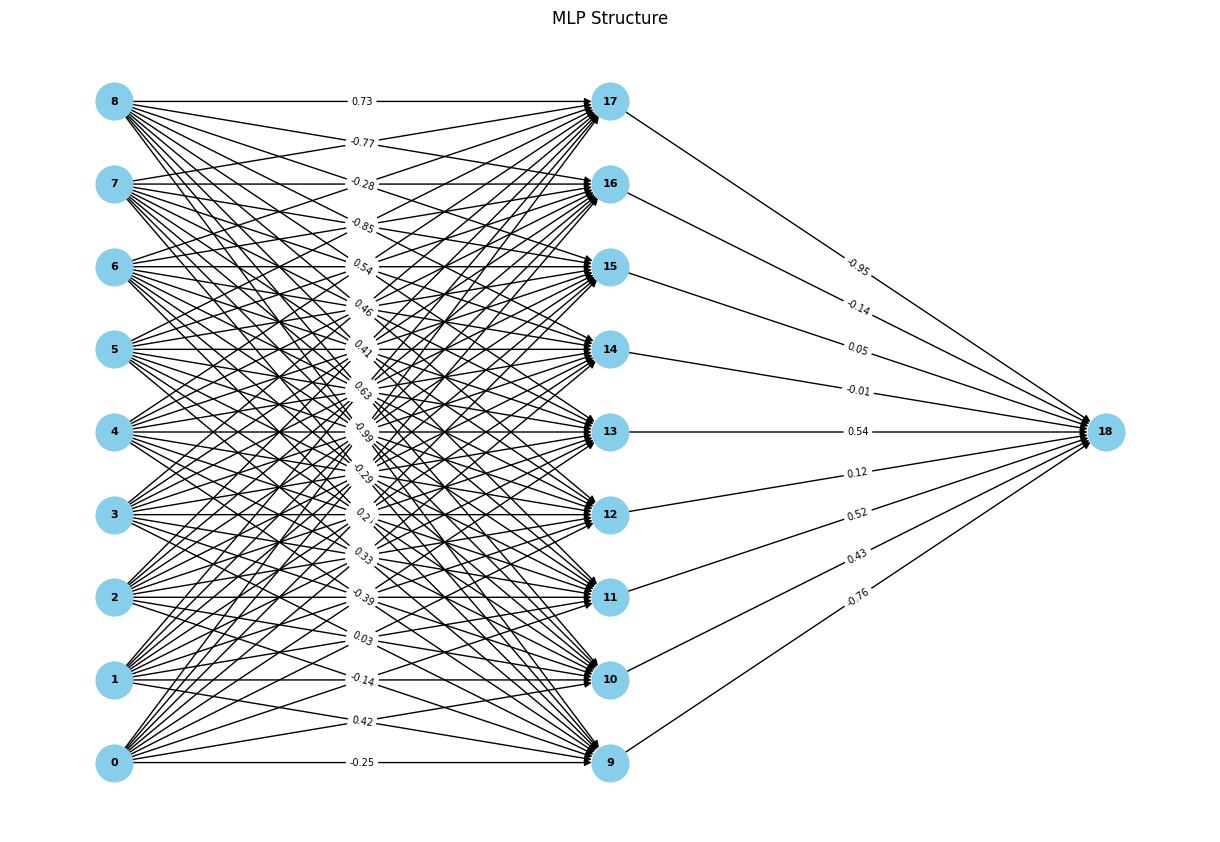

Listing all weights in the network:

Layer 1 to Layer 2:
  Weight from Neuron 0 in Layer 1 to Neuron 0 in Layer 2: -0.2509
  Weight from Neuron 0 in Layer 1 to Neuron 1 in Layer 2: 0.9014
  Weight from Neuron 0 in Layer 1 to Neuron 2 in Layer 2: 0.4640
  Weight from Neuron 0 in Layer 1 to Neuron 3 in Layer 2: 0.1973
  Weight from Neuron 0 in Layer 1 to Neuron 4 in Layer 2: -0.6880
  Weight from Neuron 0 in Layer 1 to Neuron 5 in Layer 2: -0.6880
  Weight from Neuron 0 in Layer 1 to Neuron 6 in Layer 2: -0.8838
  Weight from Neuron 0 in Layer 1 to Neuron 7 in Layer 2: 0.7324
  Weight from Neuron 0 in Layer 1 to Neuron 8 in Layer 2: 0.2022
  Weight from Neuron 1 in Layer 1 to Neuron 0 in Layer 2: 0.4161
  Weight from Neuron 1 in Layer 1 to Neuron 1 in Layer 2: -0.9588
  Weight from Neuron 1 in Layer 1 to Neuron 2 in Layer 2: 0.9398
  Weight from Neuron 1 in Layer 1 to Neuron 3 in Layer 2: 0.6649
  Weight from Neuron 1 in Layer 1 to Neuron 4 in Layer 2: -0.5753
  Weight from Neuron 1 in L

In [183]:
layers = (9, 9, 1)  # Especifica 3 camadas: 9 de entrada, 9 ocultas, 1 de saída
mlp = MLP(*layers)

# Plotar a rede
mlp.plot_network()
# Listar os pesos da rede
mlp.list_weights()

## Testando diferentes modelos (7 modelos)
### Comparando as métricas e a loss dos 7 modelos

In [184]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

california_data = fetch_california_housing(as_frame=True)
california_df = california_data.frame

# Separar entradas (features) e saída (target)
X = california_df.drop("MedHouseVal", axis=1).values
y = california_df["MedHouseVal"].values

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normaliza entre 0 e 1
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normaliza a saída entre 0 e 1

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Listar configurações para os 7 modelos
models_config = [
    (8, 10, 1),  # 1 camada oculta, 10 neurônios
    (8, 20, 1),  # 1 camada oculta, 20 neurônios
    (8, 30, 1),  # 1 camada oculta, 30 neurônios
    (8, 40, 1),  # 1 camada oculta, 40 neurônios
    (8, 10, 10, 1),  # 2 camadas ocultas, 10 neurônios em cada
    (8, 20, 20, 1),  # 2 camadas ocultas, 20 neurônios em cada
    (8, 30, 30, 1),  # 2 camadas ocultas, 30 neurônios em cada
]

# Treinar os 8 modelos e coletar resultados
results = []

for config in models_config:
    mlp = MLP(*config, learning_rate=0.01)  # Criar MLP com a configuração
    train_loss = []
    test_loss = []
    epochs = 50
    batch_size = 32

    for epoch in range(epochs):
        total_train_error = 0
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]

        for i in range(0, len(X_train), batch_size):
            batch_inputs = X_train[i:i + batch_size]
            batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)
            mlp.forward_propagation(batch_inputs)
            mlp.backward_propagation(batch_outputs)
            total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

        avg_train_error = total_train_error / len(X_train)
        train_loss.append(avg_train_error)

        total_test_error = 0
        for i in range(0, len(X_test), batch_size):
            batch_inputs = X_test[i:i + batch_size]
            batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
            predictions = mlp.forward_propagation(batch_inputs)
            total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

        avg_test_error = total_test_error / len(X_test)
        test_loss.append(avg_test_error)

    # Testar o modelo e coletar as métricas
    predictions, mse, mae, r2 = mlp.test_model(X_test, y_test)
    
    # Armazenar os resultados
    results.append({
        'Model': config,
        'MSE': mse,
        'MAE': mae,
        'R²': r2
    })

In [185]:
import pandas as pd

# Converter os resultados para um DataFrame
df_results = pd.DataFrame(results)

# Função para destacar o menor valor de cada coluna
def highlight_best(x):
    # Aplica uma cor de fundo no menor valor de cada coluna
    df = x.copy()
    for col in df.columns:
        # Destacar o menor valor
        min_value = df[col].min()
        df[col] = df[col].apply(lambda val: 'background-color: red' if val == min_value else '')
    return df

# Exibir a tabela com os resultados destacados
styled_results = df_results.style.apply(highlight_best, axis=None)
import IPython.display as display
display.display(styled_results)

,Model,MSE,MAE,R²
0,"(8, 10, 1)",0.027432,0.113634,0.507576
1,"(8, 20, 1)",0.019901,0.100619,0.642766
2,"(8, 30, 1)",0.030950,0.124292,0.444420
3,"(8, 40, 1)",0.021162,0.104938,0.620135
4,"(8, 10, 10, 1)",0.057160,0.195315,-0.026063
5,"(8, 20, 20, 1)",0.056796,0.193855,-0.019526
6,"(8, 30, 30, 1)",0.055978,0.183247,-0.004843


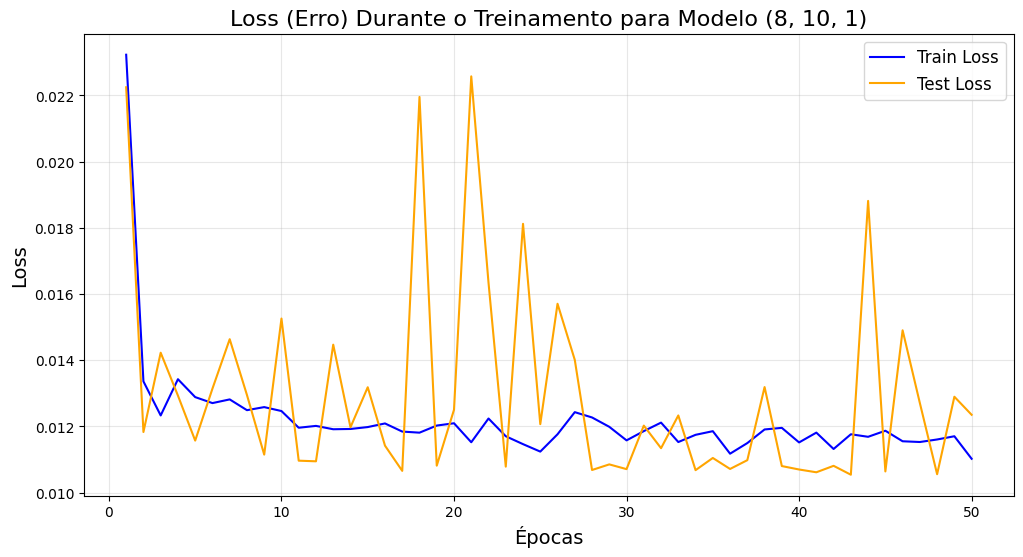

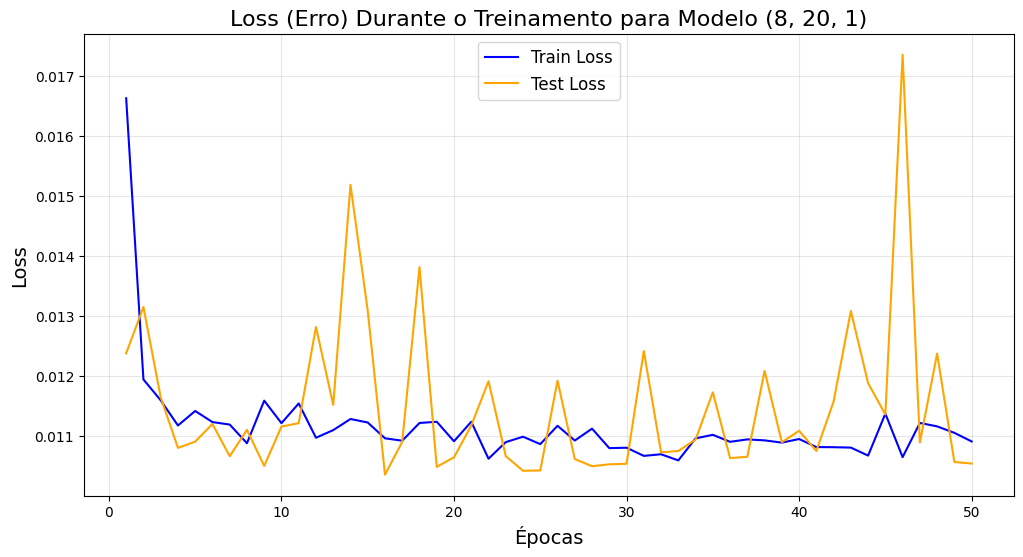

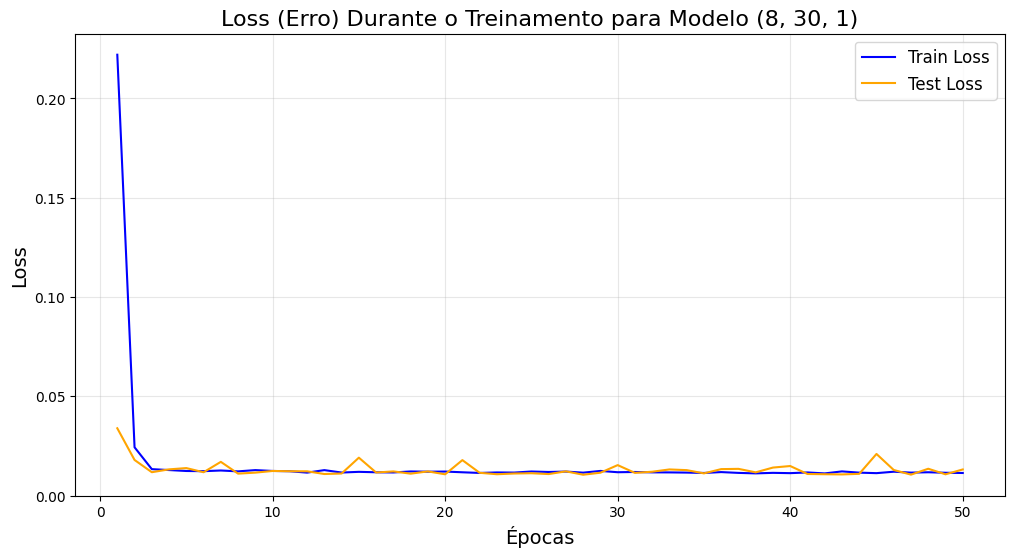

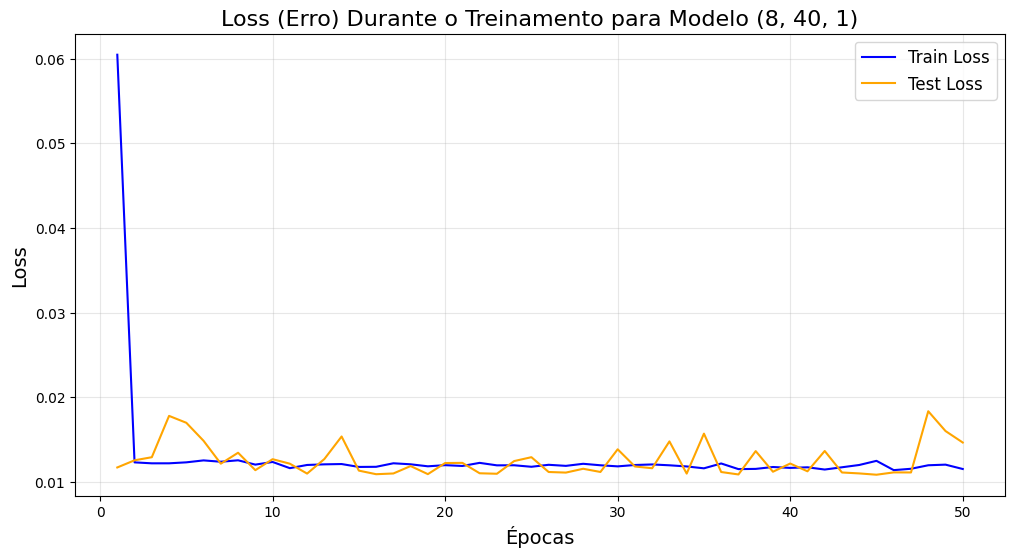

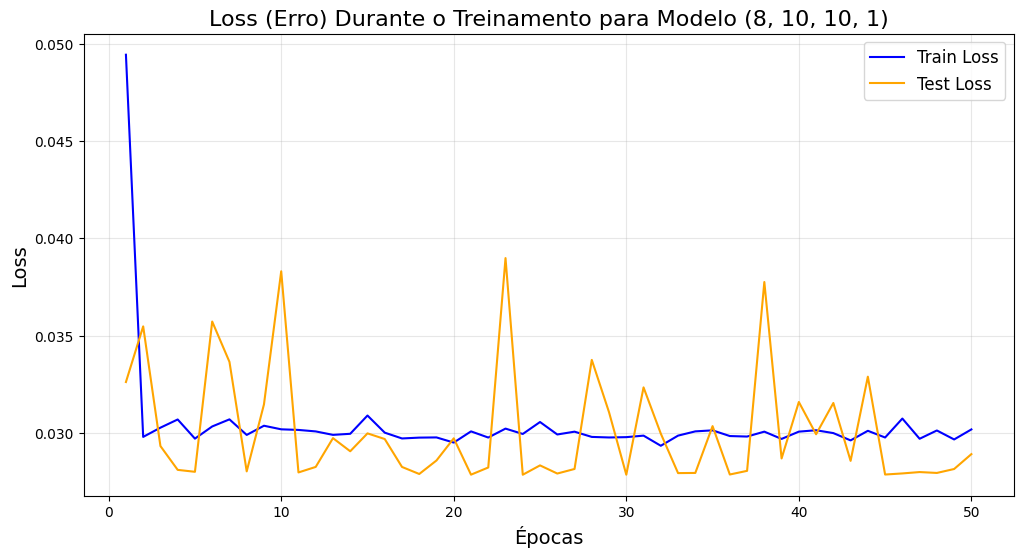

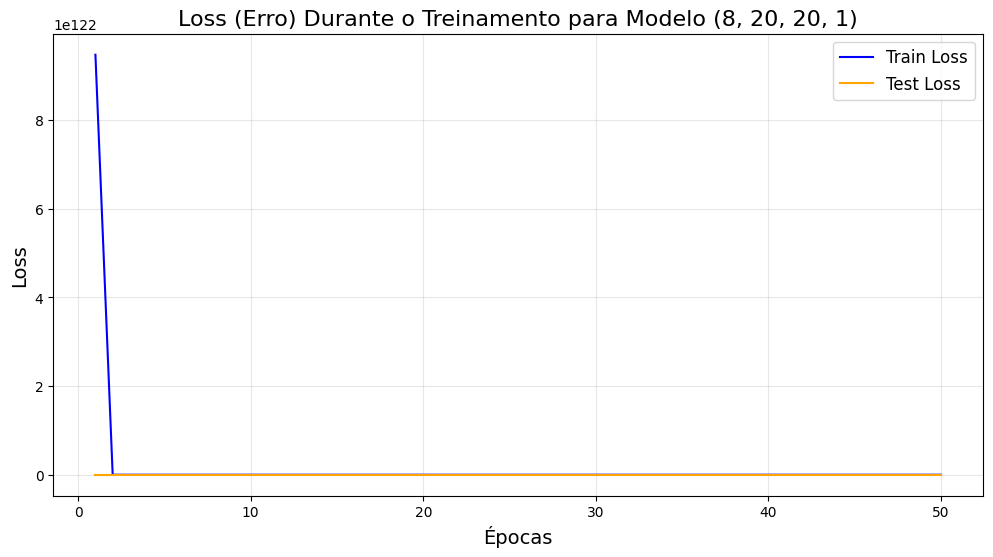

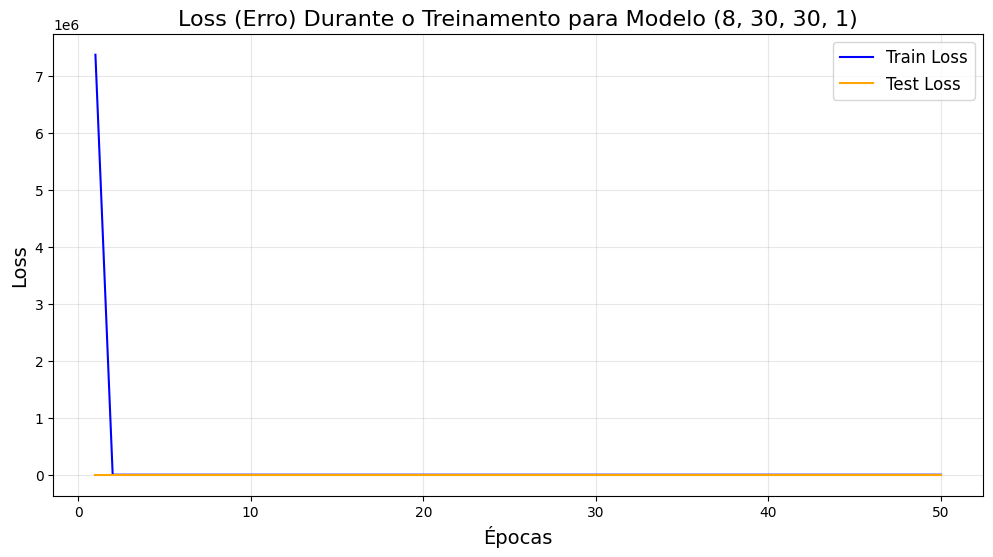

In [186]:
for idx, config in enumerate(models_config):
    mlp = MLP(*config, learning_rate=0.01)
    train_loss = []
    test_loss = []
    epochs = 50
    batch_size = 32

    for epoch in range(epochs):
        total_train_error = 0
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]

        for i in range(0, len(X_train), batch_size):
            batch_inputs = X_train[i:i + batch_size]
            batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)
            mlp.forward_propagation(batch_inputs)
            mlp.backward_propagation(batch_outputs)
            total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

        avg_train_error = total_train_error / len(X_train)
        train_loss.append(avg_train_error)

        total_test_error = 0
        for i in range(0, len(X_test), batch_size):
            batch_inputs = X_test[i:i + batch_size]
            batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
            predictions = mlp.forward_propagation(batch_inputs)
            total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

        avg_test_error = total_test_error / len(X_test)
        test_loss.append(avg_test_error)

    # Plotar o gráfico de loss para cada modelo
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", color='blue')
    plt.plot(range(1, epochs + 1), test_loss, label="Test Loss", color='orange')
    plt.title(f"Loss (Erro) Durante o Treinamento para Modelo {config}", fontsize=16)
    plt.xlabel("Épocas", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

## Fixando uma rede MLP  MLP(8, 30, 1), mas com diferentes Learning Rate

### Vendo as métricas e as loss

In [187]:
# Carregar o dataset
california_data = fetch_california_housing(as_frame=True)
california_df = california_data.frame

# Separar entradas (features) e saída (target)
X = california_df.drop("MedHouseVal", axis=1).values
y = california_df["MedHouseVal"].values

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normaliza entre 0 e 1
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Normaliza a saída entre 0 e 1

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Variações do learning rate
learning_rates = [0.1, 0.01, 0.001]
results_lr = []

for lr in learning_rates:
    mlp = MLP(8, 30, 1, learning_rate=lr, momentum=0.9)  # Criar MLP com a configuração
    train_loss = []
    test_loss = []
    epochs = 50
    batch_size = 32

    for epoch in range(epochs):
        total_train_error = 0
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]

        for i in range(0, len(X_train), batch_size):
            batch_inputs = X_train[i:i + batch_size]
            batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)
            mlp.forward_propagation(batch_inputs)
            mlp.backward_propagation(batch_outputs)
            total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

        avg_train_error = total_train_error / len(X_train)
        train_loss.append(avg_train_error)

        total_test_error = 0
        for i in range(0, len(X_test), batch_size):
            batch_inputs = X_test[i:i + batch_size]
            batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
            predictions = mlp.forward_propagation(batch_inputs)
            total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

        avg_test_error = total_test_error / len(X_test)
        test_loss.append(avg_test_error)

    # Testar o modelo e coletar as métricas
    predictions, mse, mae, r2 = mlp.test_model(X_test, y_test)
    
    # Armazenar resultados
    results_lr.append({
        'Learning Rate': lr,
        'MSE': mse,
        'MAE': mae,
        'R²': r2
    })

In [188]:
# Converter os resultados para um DataFrame
df_results_lr = pd.DataFrame(results_lr)

# Função para destacar o menor valor de cada coluna
def highlight_best(x):
    # Aplica uma cor de fundo no menor valor de cada coluna
    df = x.copy()
    for col in df.columns:
        # Destacar o menor valor
        min_value = df[col].min()
        df[col] = df[col].apply(lambda val: 'background-color: red' if val == min_value else '')
    return df

# Exibir a tabela com os resultados destacados
styled_results_lr = df_results_lr.style.apply(highlight_best, axis=None)

# Exibir a tabela com o estilo aplicado
import IPython.display as display
display.display(styled_results_lr)

,Learning Rate,MSE,MAE,R²
0,0.100000,0.199820,0.379631,-2.586901
1,0.010000,0.021958,0.105978,0.605834
2,0.001000,0.020845,0.103096,0.625812


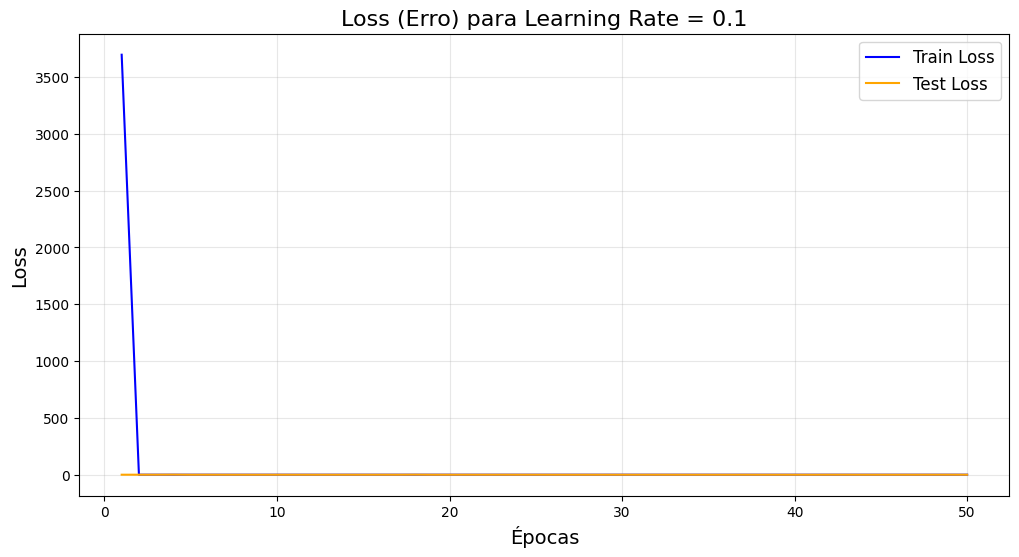

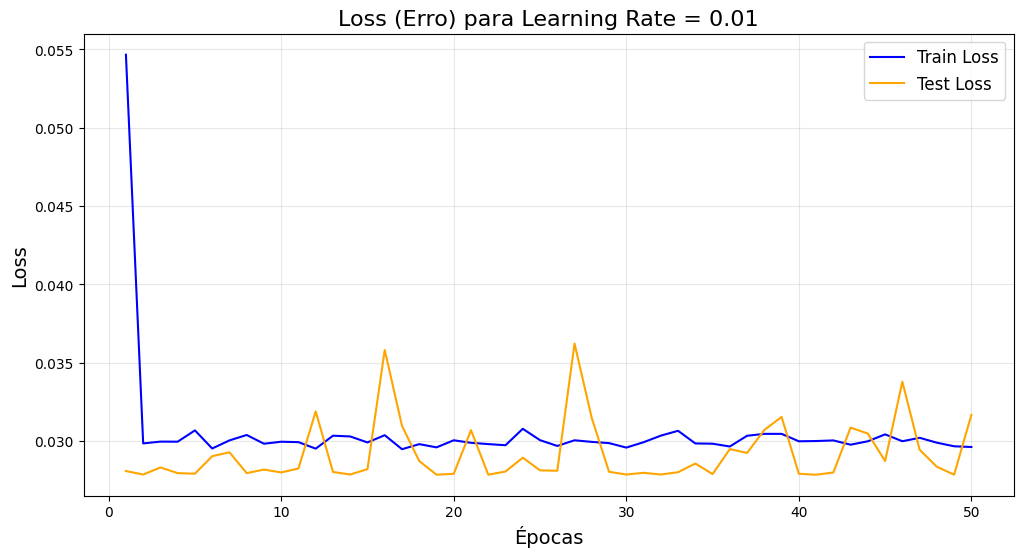

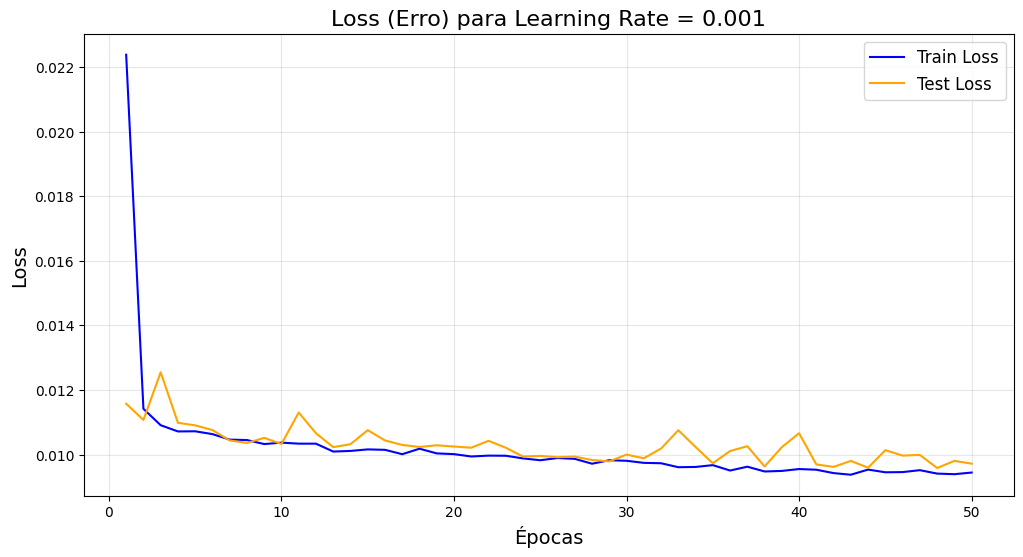

In [189]:
# 3º Código - Gráficos da Loss (Train e Test)

for lr in learning_rates:
    mlp = MLP(8, 10, 10, 1, learning_rate=lr, momentum=0.9)
    train_loss = []
    test_loss = []
    epochs = 50
    batch_size = 32

    for epoch in range(epochs):
        total_train_error = 0
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]

        for i in range(0, len(X_train), batch_size):
            batch_inputs = X_train[i:i + batch_size]
            batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)
            mlp.forward_propagation(batch_inputs)
            mlp.backward_propagation(batch_outputs)
            total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

        avg_train_error = total_train_error / len(X_train)
        train_loss.append(avg_train_error)

        total_test_error = 0
        for i in range(0, len(X_test), batch_size):
            batch_inputs = X_test[i:i + batch_size]
            batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
            predictions = mlp.forward_propagation(batch_inputs)
            total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

        avg_test_error = total_test_error / len(X_test)
        test_loss.append(avg_test_error)

    # Plotar a loss de treino e teste para cada valor de learning rate
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 51), train_loss, label="Train Loss", color='blue')
    plt.plot(range(1, 51), test_loss, label="Test Loss", color='orange')
    plt.title(f"Loss (Erro) para Learning Rate = {lr}", fontsize=16)
    plt.xlabel("Épocas", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

## Fixando uma rede MLP  MLP(8, 30, 1), fixando a Learning Rate (0.001), mas com diferentes momentos

### Vendo as métricas e as loss dos momentos

In [ ]:

momentums = [0.9, 0.7, 0.5, 0.3, 0.1]
results_momentum = []

for m in momentums:
    mlp = MLP(8, 30, 1, learning_rate=0.001, momentum=m)  # Configuração do modelo
    train_loss = []
    test_loss = []
    epochs = 50
    batch_size = 32

    for epoch in range(epochs):
        total_train_error = 0
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]

        for i in range(0, len(X_train), batch_size):
            batch_inputs = X_train[i:i + batch_size]
            batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)
            mlp.forward_propagation(batch_inputs)
            mlp.backward_propagation(batch_outputs)
            total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

        avg_train_error = total_train_error / len(X_train)
        train_loss.append(avg_train_error)

        total_test_error = 0
        for i in range(0, len(X_test), batch_size):
            batch_inputs = X_test[i:i + batch_size]
            batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
            predictions = mlp.forward_propagation(batch_inputs)
            total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

        avg_test_error = total_test_error / len(X_test)
        test_loss.append(avg_test_error)

    # Testar o modelo e coletar as métricas
    predictions, mse, mae, r2 = mlp.test_model(X_test, y_test)
    
    # Armazenar resultados
    results_momentum.append({
        'Momentum': m,
        'MSE': mse,
        'MAE': mae,
        'R²': r2
    })

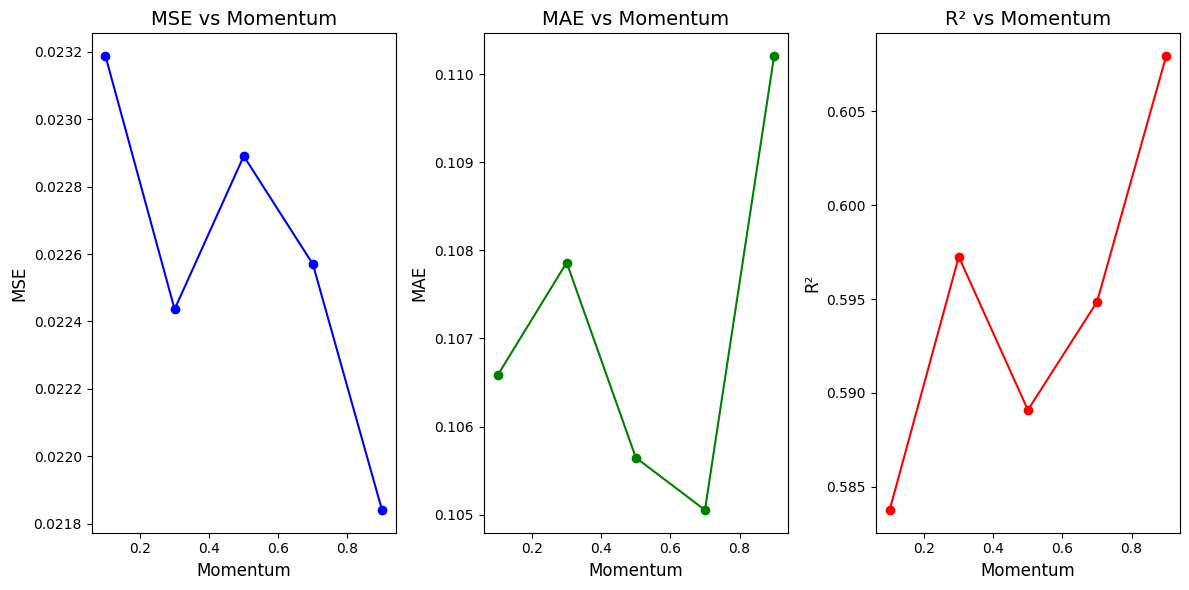

In [191]:
df_results_momentum = pd.DataFrame(results_momentum)

# Plotar os gráficos das métricas
plt.figure(figsize=(12, 6))

# MSE
plt.subplot(131)
plt.plot(df_results_momentum['Momentum'], df_results_momentum['MSE'], marker='o', color='blue')
plt.title("MSE vs Momentum", fontsize=14)
plt.xlabel("Momentum", fontsize=12)
plt.ylabel("MSE", fontsize=12)

# MAE
plt.subplot(132)
plt.plot(df_results_momentum['Momentum'], df_results_momentum['MAE'], marker='o', color='green')
plt.title("MAE vs Momentum", fontsize=14)
plt.xlabel("Momentum", fontsize=12)
plt.ylabel("MAE", fontsize=12)

# R²
plt.subplot(133)
plt.plot(df_results_momentum['Momentum'], df_results_momentum['R²'], marker='o', color='red')
plt.title("R² vs Momentum", fontsize=14)
plt.xlabel("Momentum", fontsize=12)
plt.ylabel("R²", fontsize=12)

plt.tight_layout()
plt.show()

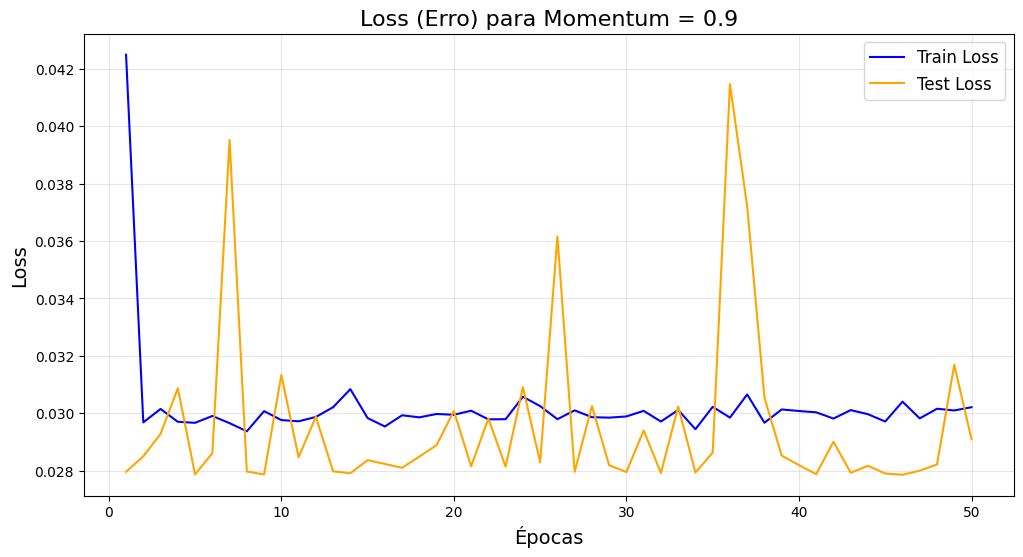

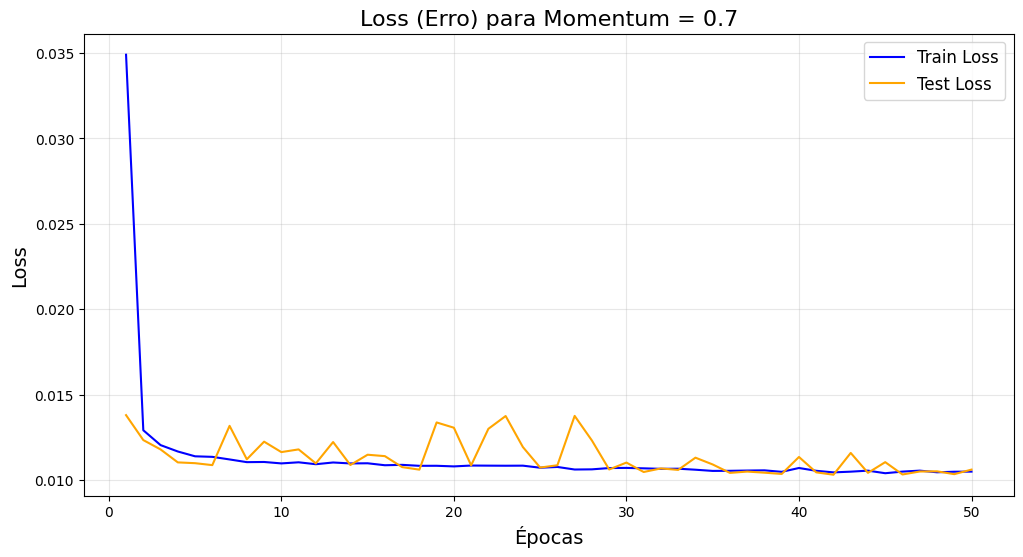

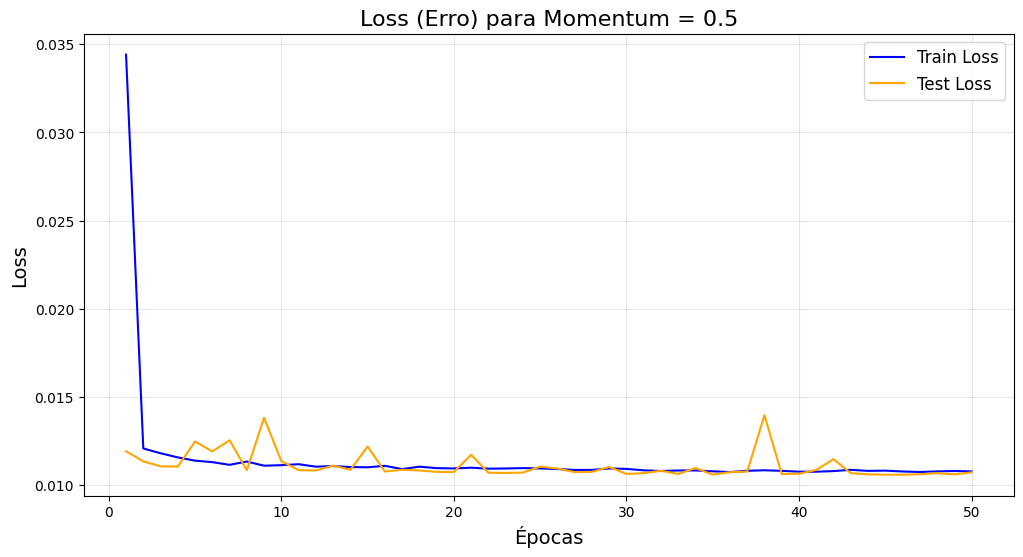

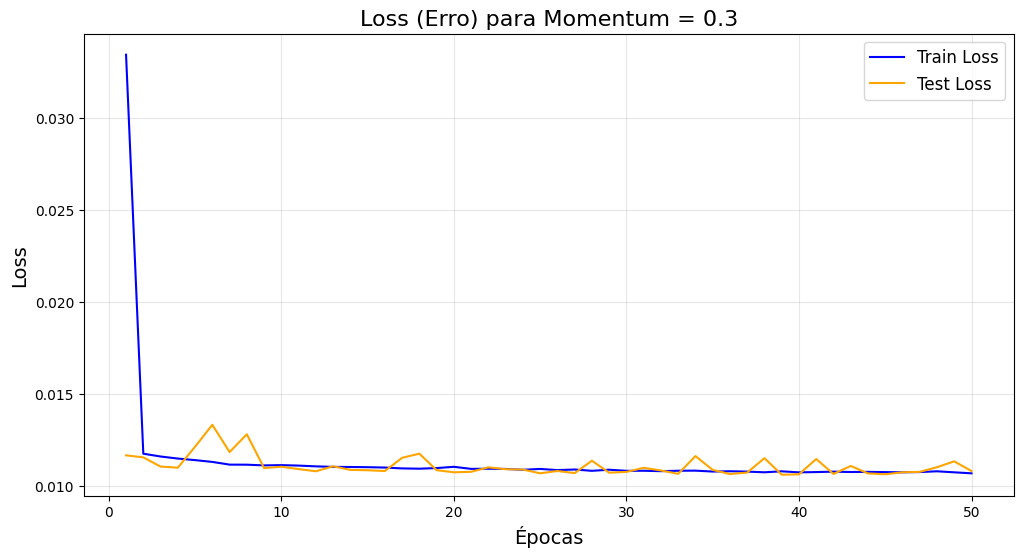

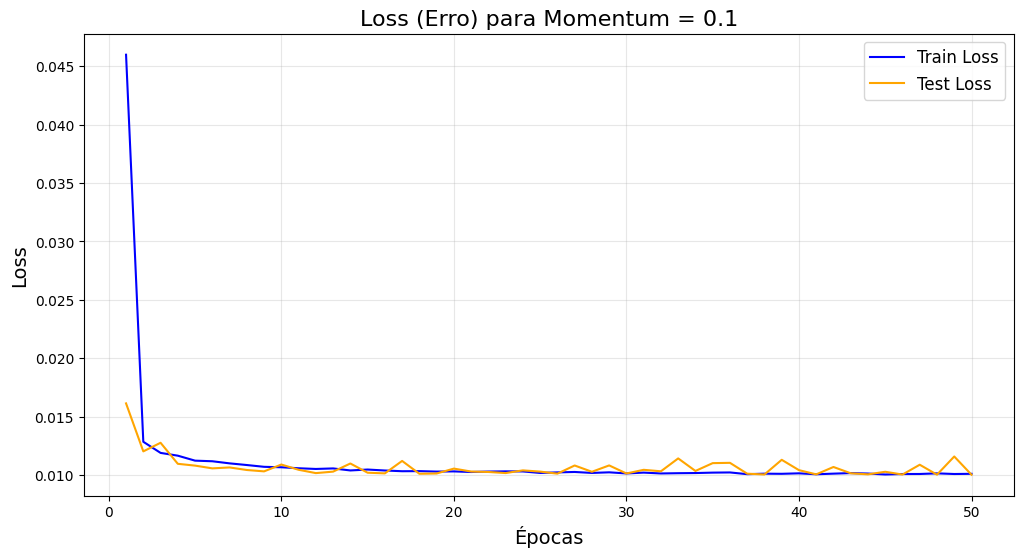

In [192]:
for m in momentums:
    mlp = MLP(8, 10, 10, 1, learning_rate=0.01, momentum=m)  # Configuração do modelo
    train_loss = []
    test_loss = []
    epochs = 50
    batch_size = 32

    for epoch in range(epochs):
        total_train_error = 0
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]

        for i in range(0, len(X_train), batch_size):
            batch_inputs = X_train[i:i + batch_size]
            batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)
            mlp.forward_propagation(batch_inputs)
            mlp.backward_propagation(batch_outputs)
            total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

        avg_train_error = total_train_error / len(X_train)
        train_loss.append(avg_train_error)

        total_test_error = 0
        for i in range(0, len(X_test), batch_size):
            batch_inputs = X_test[i:i + batch_size]
            batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
            predictions = mlp.forward_propagation(batch_inputs)
            total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

        avg_test_error = total_test_error / len(X_test)
        test_loss.append(avg_test_error)

    # Plotar a loss de treino e teste para cada valor de momentum
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 51), train_loss, label="Train Loss", color='blue')
    plt.plot(range(1, 51), test_loss, label="Test Loss", color='orange')
    plt.title(f"Loss (Erro) para Momentum = {m}", fontsize=16)
    plt.xlabel("Épocas", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Classificação

## dataset: diabetes (sklearn)

In [193]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

# Funções de Ativação
class ActivationFunctions:
    @staticmethod
    def relu(x):
        if isinstance(x, list):
            return [max(0, value) for value in x]
        return max(0, x)

    @staticmethod
    def relu_derivative(x):
        if isinstance(x, list):
            return [1 if value > 0 else 0 for value in x]
        return 1 if x > 0 else 0

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))  # Substituir math.exp por np.exp

    @staticmethod
    def sigmoid_derivative(x):
        sigmoid_value = ActivationFunctions.sigmoid(x)
        return sigmoid_value * (1 - sigmoid_value)

In [194]:
# Rede Neural MLP
class MLP:
    def __init__(self, *layers, learning_rate=0.01, momentum=0.9, random_seed=42):
        """
        Inicializa a estrutura da MLP.

        :param layers: Número de neurônios em cada camada, incluindo entrada, ocultas e saída.
        :param learning_rate: Taxa de aprendizado.
        :param momentum: Fator de momento para a descida do gradiente.
        :param random_seed: Semente para inicialização de pesos.
        """
        self.layers_sizes = layers
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.random_seed = random_seed  # Semente para controle de aleatoriedade
        self.weights = []
        self.biases = []
        self.velocities_weights = []  # Velocidades para os pesos
        self.velocities_biases = []   # Velocidades para os vieses
        self.outputs = []
        self.initialize_network()

    def initialize_network(self):
        np.random.seed(self.random_seed)  # Definir a semente para garantir a consistência

        for i in range(len(self.layers_sizes) - 1):
            input_neurons = self.layers_sizes[i]
            output_neurons = self.layers_sizes[i + 1]
            self.weights.append(np.random.uniform(-1, 1, (input_neurons, output_neurons)))
            self.biases.append(np.random.uniform(-1, 1, output_neurons))
            self.velocities_weights.append(np.zeros((input_neurons, output_neurons)))
            self.velocities_biases.append(np.zeros(output_neurons))

    def calculate_z(self, inputs, weights, biases):
        return np.dot(inputs, weights) + biases

    def forward_propagation(self, inputs):
        self.outputs = [np.array(inputs)]
        current_output = self.outputs[0]
        for i in range(len(self.weights)):
            z = self.calculate_z(current_output, self.weights[i], self.biases[i])
            if i < len(self.weights) - 1:
                current_output = np.maximum(0, z)  # ReLU
            else:
                current_output = ActivationFunctions.sigmoid(z)  # Sigmoid para saída
            self.outputs.append(np.array(current_output))

        return current_output

    def backward_propagation(self, expected_output):
        expected_output = np.array(expected_output)
        deltas = [None] * len(self.weights)
        errors = expected_output - self.outputs[-1]
        deltas[-1] = errors * ActivationFunctions.sigmoid_derivative(self.outputs[-1])  # Derivada da sigmoid

        for i in range(len(self.weights) - 2, -1, -1):
            z_derivative = (self.outputs[i + 1] > 0).astype(float)
            deltas[i] = np.dot(deltas[i + 1], self.weights[i + 1].T) * z_derivative

        for i in range(len(self.weights)):
            grad_weights = np.dot(self.outputs[i].T, deltas[i])
            grad_biases = np.sum(deltas[i], axis=0)
            self.velocities_weights[i] = self.momentum * self.velocities_weights[i] + self.learning_rate * grad_weights
            self.velocities_biases[i] = self.momentum * self.velocities_biases[i] + self.learning_rate * grad_biases
            self.weights[i] += self.velocities_weights[i]
            self.biases[i] += self.velocities_biases[i]

    def calculate_error(self, expected_output):
        outputs = self.outputs[-1]
        return np.mean((expected_output - outputs) ** 2) / 2

    def train(self, inputs, expected_outputs, epochs=1000, tolerance=1e-5, batch_size=32):
        errors = []
        inputs = np.array(inputs)
        expected_outputs = np.array(expected_outputs)

        for epoch in range(epochs):
            total_error = 0
            indices = np.arange(len(inputs))
            np.random.shuffle(indices)
            inputs = inputs[indices]
            expected_outputs = expected_outputs[indices]

            for i in range(0, len(inputs), batch_size):
                batch_inputs = inputs[i:i + batch_size]
                batch_outputs = expected_outputs[i:i + batch_size]
                self.forward_propagation(batch_inputs)
                self.backward_propagation(batch_outputs)
                total_error += np.sum((batch_outputs - self.outputs[-1]) ** 2) / 2

            mean_error = total_error / len(inputs)
            errors.append(mean_error)

            if mean_error < tolerance:
                break

        return errors

    
    def test_model(self, test_inputs, expected_outputs):
        predictions = []
        for inp in test_inputs:
            # Realiza a propagação para frente e obtém a saída da rede
            prediction = self.forward_propagation(inp)[0]
            predictions.append(prediction)

        # Converter as saídas contínuas para binárias com base em 0.5 (limite da sigmoid)
        predictions_binary = np.array([1 if pred > 0.5 else 0 for pred in predictions])
        
        # Calcular as métricas de desempenho
        accuracy = accuracy_score(expected_outputs, predictions_binary)
        balanced_accuracy = balanced_accuracy_score(expected_outputs, predictions_binary)
        f1 = f1_score(expected_outputs, predictions_binary)
        precision = precision_score(expected_outputs, predictions_binary)
        recall = recall_score(expected_outputs, predictions_binary)

        # Retornar as métricas de classificação
        return predictions_binary, accuracy, balanced_accuracy, f1, precision, recall

## Testando diferentes modelos (7 modelos)
### Comparando as métricas e a loss dos 7 modelos

In [195]:
# Carregar o dataset diabetes
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
y = np.where(y > np.median(y), 1, 0)  # Transformando em classificação binária: 1 = diabetes, 0 = não

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Listar configurações para os 7 modelos
models_config = [
    (10, 10, 1),  # 1 camada oculta, 10 neurônios
    (10, 20, 1),  # 1 camada oculta, 20 neurônios
    (10, 30, 1),  # 1 camada oculta, 30 neurônios
    (10, 40, 1),  # 1 camada oculta, 40 neurônios
    (10, 10, 10, 1),  # 2 camadas ocultas, 10 neurônios em cada
    (10, 20, 20, 1),  # 2 camadas ocultas, 20 neurônios em cada
    (10, 30, 30, 1),  # 2 camadas ocultas, 30 neurônios em cada
]

# Armazenar os resultados
results = []

# Testar os 7 modelos e coletar resultados
for config in models_config:
    mlp = MLP(*config, learning_rate=0.01, momentum=0.9)  # Criar MLP com a configuração
    train_loss = []
    test_loss = []
    epochs = 50
    batch_size = 32

    for epoch in range(epochs):
        total_train_error = 0
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]

        for i in range(0, len(X_train), batch_size):
            batch_inputs = X_train[i:i + batch_size]
            batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)
            mlp.forward_propagation(batch_inputs)
            mlp.backward_propagation(batch_outputs)
            total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

        avg_train_error = total_train_error / len(X_train)
        train_loss.append(avg_train_error)

        total_test_error = 0
        for i in range(0, len(X_test), batch_size):
            batch_inputs = X_test[i:i + batch_size]
            batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
            predictions = mlp.forward_propagation(batch_inputs)
            total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

        avg_test_error = total_test_error / len(X_test)
        test_loss.append(avg_test_error)

    # Avaliar o modelo
    predictions, accuracy, balanced_accuracy, f1, precision, recall = mlp.test_model(X_test, y_test)

    # Armazenar os resultados
    results.append({
        'Model': config,
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall
    })

In [196]:

# Converter os resultados para um DataFrame
df_results = pd.DataFrame(results)

# Função para destacar o melhor valor de cada métrica
def highlight_best(x):
    df = x.copy()
    for col in df.columns:
        # Destacar o melhor valor para Accuracy, Balanced Accuracy, F1 Score, Precision, Recall
        max_value = df[col].max() if col not in ['MSE', 'MAE'] else df[col].min()  # Mínimo para MSE, MAE
        df[col] = df[col].apply(lambda val: 'background-color: red' if val == max_value else '')
    return df

# Exibir a tabela com os resultados destacados
styled_results = df_results.style.apply(highlight_best, axis=None)
import IPython.display as display
display.display(styled_results)

,Model,Accuracy,Balanced Accuracy,F1 Score,Precision,Recall
0,"(10, 10, 1)",0.730337,0.718367,0.666667,0.750000,0.600000
1,"(10, 20, 1)",0.752809,0.752551,0.731707,0.714286,0.750000
2,"(10, 30, 1)",0.730337,0.720663,0.675676,0.735294,0.625000
3,"(10, 40, 1)",0.752809,0.757143,0.744186,0.695652,0.800000
4,"(10, 10, 10, 1)",0.797753,0.802551,0.790698,0.739130,0.850000
5,"(10, 20, 20, 1)",0.730337,0.725255,0.692308,0.710526,0.675000
6,"(10, 30, 30, 1)",0.674157,0.697194,0.718447,0.587302,0.925000


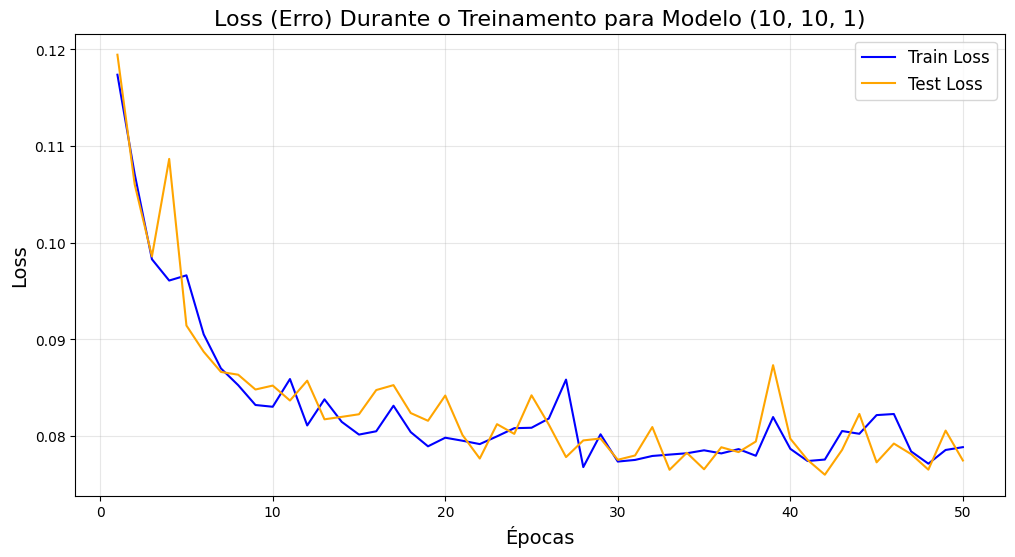

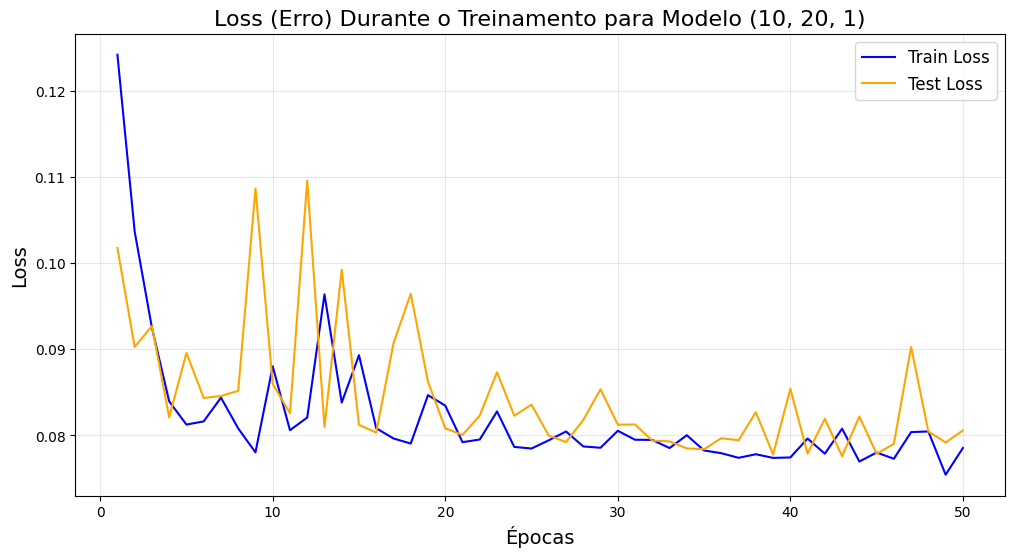

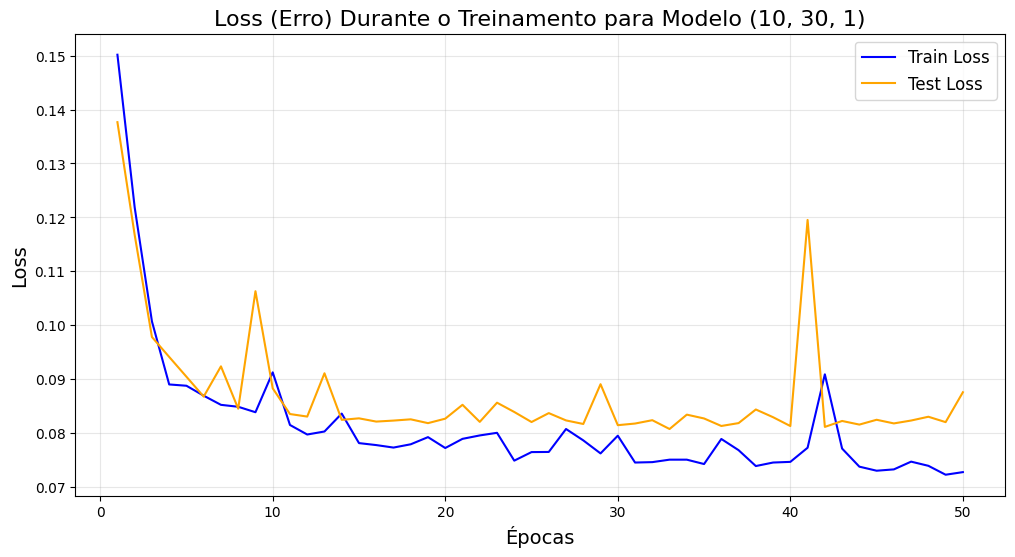

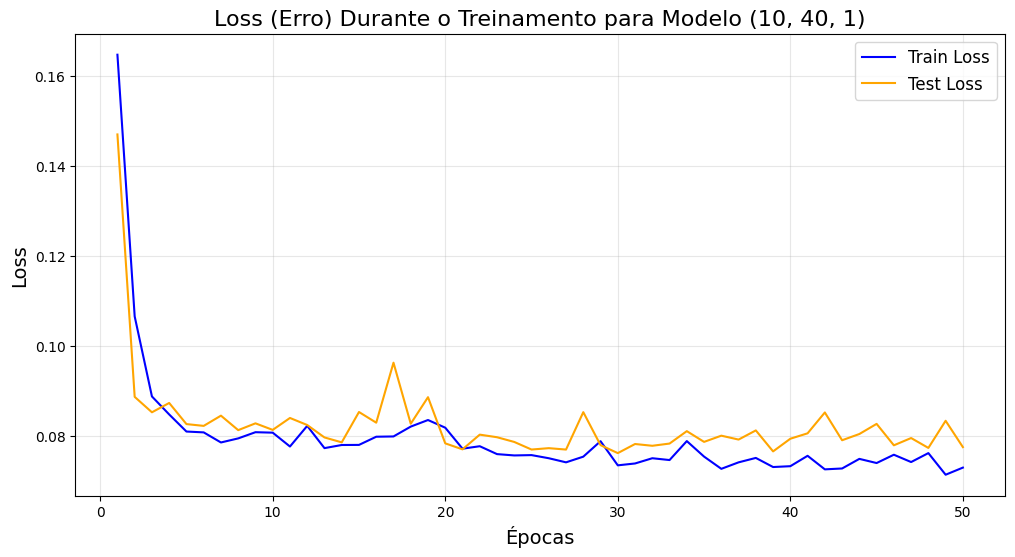

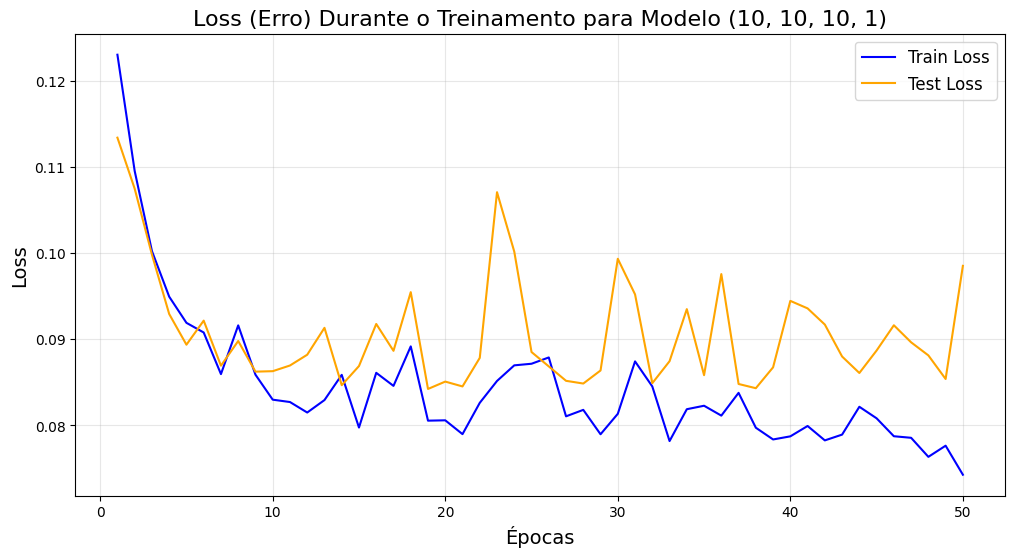

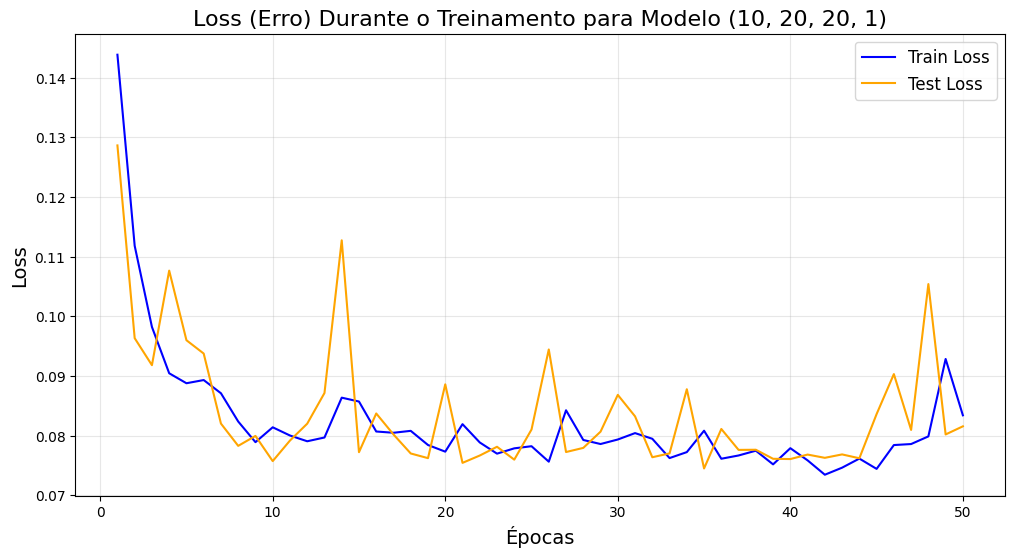

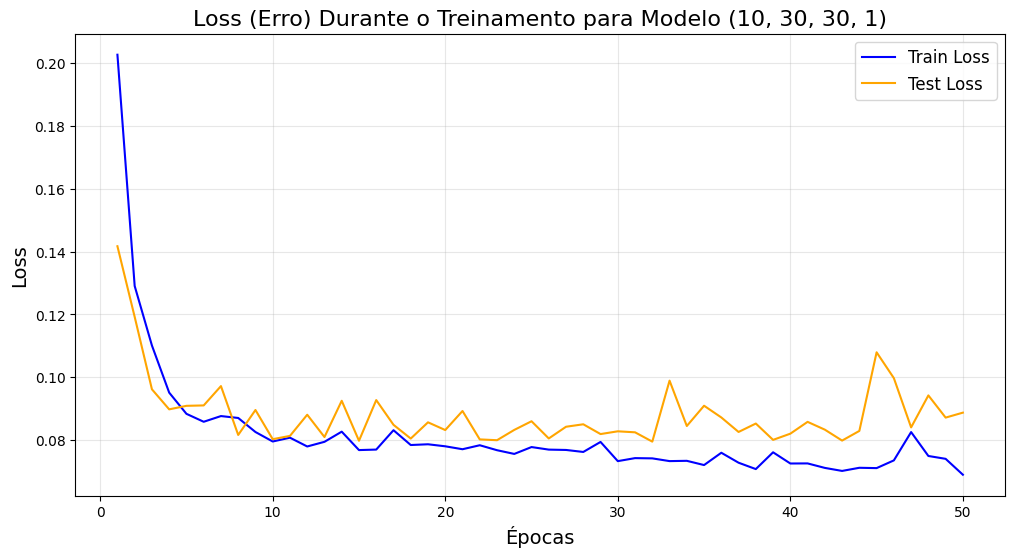

In [197]:
for config in models_config:
    mlp = MLP(*config, learning_rate=0.01, momentum=0.9)
    train_loss = []
    test_loss = []
    epochs = 50
    batch_size = 32

    for epoch in range(epochs):
        total_train_error = 0
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]

        for i in range(0, len(X_train), batch_size):
            batch_inputs = X_train[i:i + batch_size]
            batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)
            mlp.forward_propagation(batch_inputs)
            mlp.backward_propagation(batch_outputs)
            total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

        avg_train_error = total_train_error / len(X_train)
        train_loss.append(avg_train_error)

        total_test_error = 0
        for i in range(0, len(X_test), batch_size):
            batch_inputs = X_test[i:i + batch_size]
            batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
            predictions = mlp.forward_propagation(batch_inputs)
            total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

        avg_test_error = total_test_error / len(X_test)
        test_loss.append(avg_test_error)

    # Plotar a loss de treino e teste para cada modelo
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 51), train_loss, label="Train Loss", color='blue')
    plt.plot(range(1, 51), test_loss, label="Test Loss", color='orange')
    plt.title(f"Loss (Erro) Durante o Treinamento para Modelo {config}", fontsize=16)
    plt.xlabel("Épocas", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

## Fixando uma rede MLP  MLP(10, 10, 10, 1), mas com diferentes Learning Rate

### Vendo as métricas e as loss

In [198]:
# Carregar o dataset diabetes
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
y = np.where(y > np.median(y), 1, 0)  # Transformando em classificação binária: 1 = diabetes, 0 = não

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Configurações de modelos com 10 neurônios em cada camada oculta
models_config = [(10, 10, 10, 1)]  # MLP com 3 camadas (10, 10, 10)

# Resultados para diferentes learning rates
learning_rates = [0.1, 0.01, 0.001]
results_lr = []

# Testar os modelos com diferentes learning rates
for lr in learning_rates:
    mlp = MLP(10, 10, 10, 1, learning_rate=lr, momentum=0.9)  # Criar MLP com a configuração
    train_loss = []
    test_loss = []
    epochs = 50
    batch_size = 32

    for epoch in range(epochs):
        total_train_error = 0
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]

        for i in range(0, len(X_train), batch_size):
            batch_inputs = X_train[i:i + batch_size]
            batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)
            mlp.forward_propagation(batch_inputs)
            mlp.backward_propagation(batch_outputs)
            total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

        avg_train_error = total_train_error / len(X_train)
        train_loss.append(avg_train_error)

        total_test_error = 0
        for i in range(0, len(X_test), batch_size):
            batch_inputs = X_test[i:i + batch_size]
            batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
            predictions = mlp.forward_propagation(batch_inputs)
            total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

        avg_test_error = total_test_error / len(X_test)
        test_loss.append(avg_test_error)

    # Avaliar o modelo
    predictions, accuracy, balanced_accuracy, f1, precision, recall = mlp.test_model(X_test, y_test)

    # Armazenar os resultados
    results_lr.append({
        'Learning Rate': lr,
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall
    })

/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [199]:
# Converter os resultados para um DataFrame
df_results_lr = pd.DataFrame(results_lr)

# Função para destacar o melhor valor de cada métrica
def highlight_best(x):
    df = x.copy()
    for col in df.columns:
        max_value = df[col].max() if col not in ['MSE', 'MAE'] else df[col].min()  # Mínimo para MSE, MAE
        df[col] = df[col].apply(lambda val: 'background-color: red' if val == max_value else '')
    return df

# Exibir a tabela com os resultados destacados
styled_results_lr = df_results_lr.style.apply(highlight_best, axis=None)
import IPython.display as display
display.display(styled_results_lr)

,Learning Rate,Accuracy,Balanced Accuracy,F1 Score,Precision,Recall
0,0.100000,0.550562,0.500000,0.000000,0.000000,0.000000
1,0.010000,0.797753,0.804847,0.795455,0.729167,0.875000
2,0.001000,0.752809,0.752551,0.731707,0.714286,0.750000


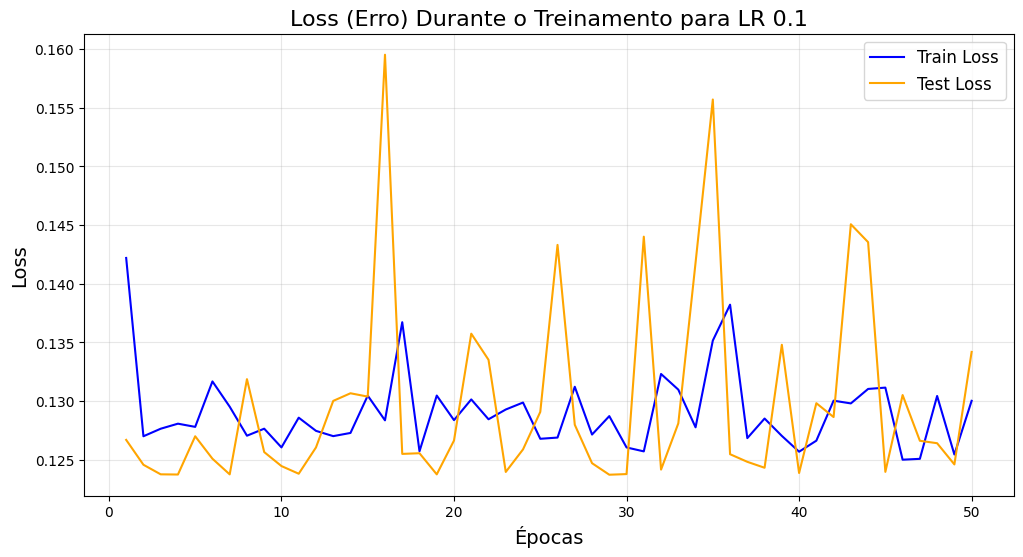

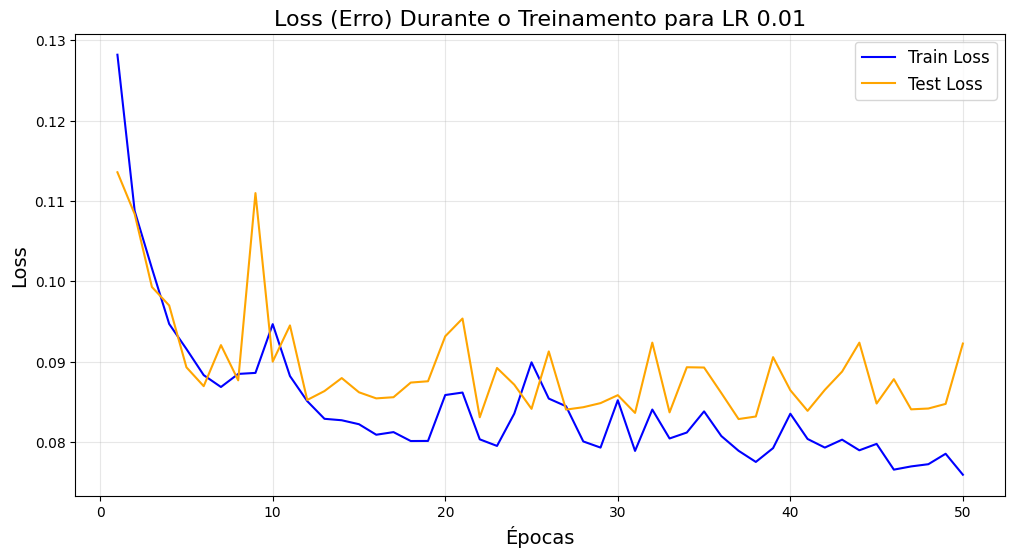

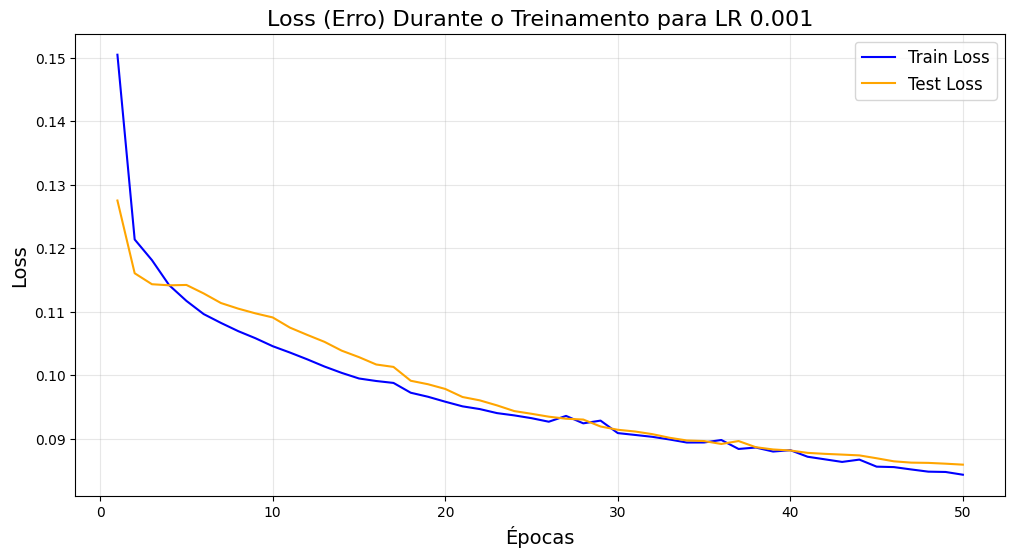

In [200]:
# Plotar a Loss de Treinamento e Teste para cada Learning Rate
for idx, lr in enumerate(learning_rates):
    mlp = MLP(10, 10, 10, 1, learning_rate=lr, momentum=0.9)
    train_loss = []
    test_loss = []
    epochs = 50
    batch_size = 32

    for epoch in range(epochs):
        total_train_error = 0
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]

        for i in range(0, len(X_train), batch_size):
            batch_inputs = X_train[i:i + batch_size]
            batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)
            mlp.forward_propagation(batch_inputs)
            mlp.backward_propagation(batch_outputs)
            total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

        avg_train_error = total_train_error / len(X_train)
        train_loss.append(avg_train_error)

        total_test_error = 0
        for i in range(0, len(X_test), batch_size):
            batch_inputs = X_test[i:i + batch_size]
            batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
            predictions = mlp.forward_propagation(batch_inputs)
            total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

        avg_test_error = total_test_error / len(X_test)
        test_loss.append(avg_test_error)

    # Plotar a loss de treino e teste para cada modelo
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 51), train_loss, label="Train Loss", color='blue')
    plt.plot(range(1, 51), test_loss, label="Test Loss", color='orange')
    plt.title(f"Loss (Erro) Durante o Treinamento para LR {lr}", fontsize=16)
    plt.xlabel("Épocas", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

## Fixando uma rede MLP  MLP(10, 10, 10, 1) fixando a Learning Rate (0.1), mas com diferentes momentos

### Vendo as métricas e as loss dos momentos

In [201]:
# Testar diferentes valores de momentum com Learning Rate fixo em 0.1
momentums = [0.9, 0.7, 0.5, 0.3, 0.01]
results_momentum = []

for momentum in momentums:
    mlp = MLP(10, 10, 10, 1, learning_rate=0.1, momentum=momentum)
    train_loss = []
    test_loss = []
    epochs = 50
    batch_size = 32

    for epoch in range(epochs):
        total_train_error = 0
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]

        for i in range(0, len(X_train), batch_size):
            batch_inputs = X_train[i:i + batch_size]
            batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)
            mlp.forward_propagation(batch_inputs)
            mlp.backward_propagation(batch_outputs)
            total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

        avg_train_error = total_train_error / len(X_train)
        train_loss.append(avg_train_error)

        total_test_error = 0
        for i in range(0, len(X_test), batch_size):
            batch_inputs = X_test[i:i + batch_size]
            batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
            predictions = mlp.forward_propagation(batch_inputs)
            total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

        avg_test_error = total_test_error / len(X_test)
        test_loss.append(avg_test_error)

    # Avaliar o modelo
    predictions, accuracy, balanced_accuracy, f1, precision, recall = mlp.test_model(X_test, y_test)

    # Armazenar os resultados
    results_momentum.append({
        'Momentum': momentum,
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall
    })

/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


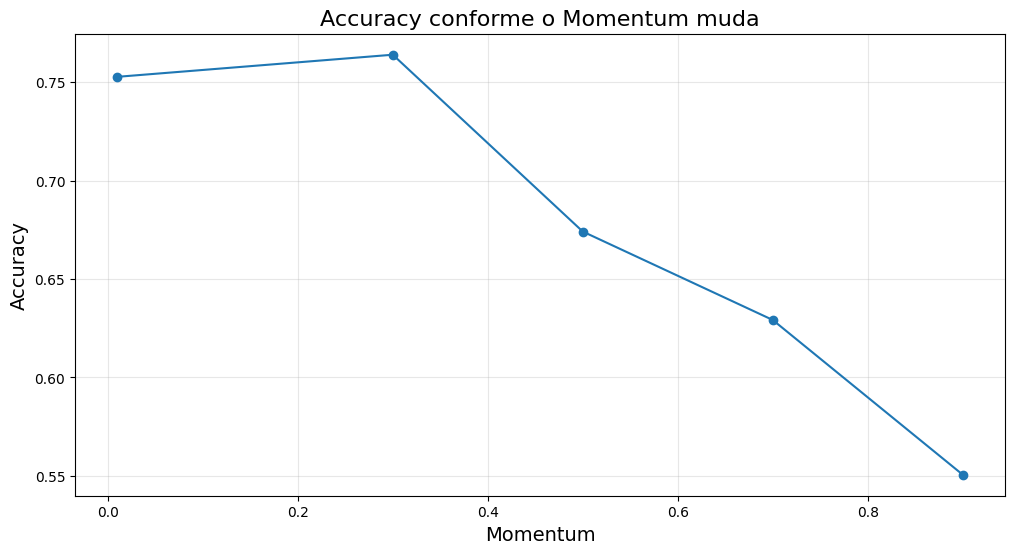

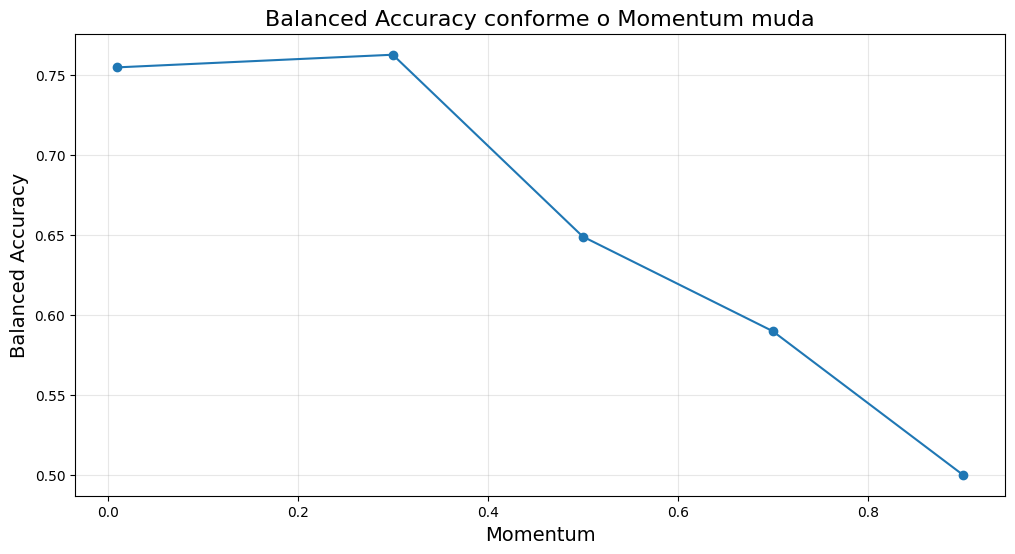

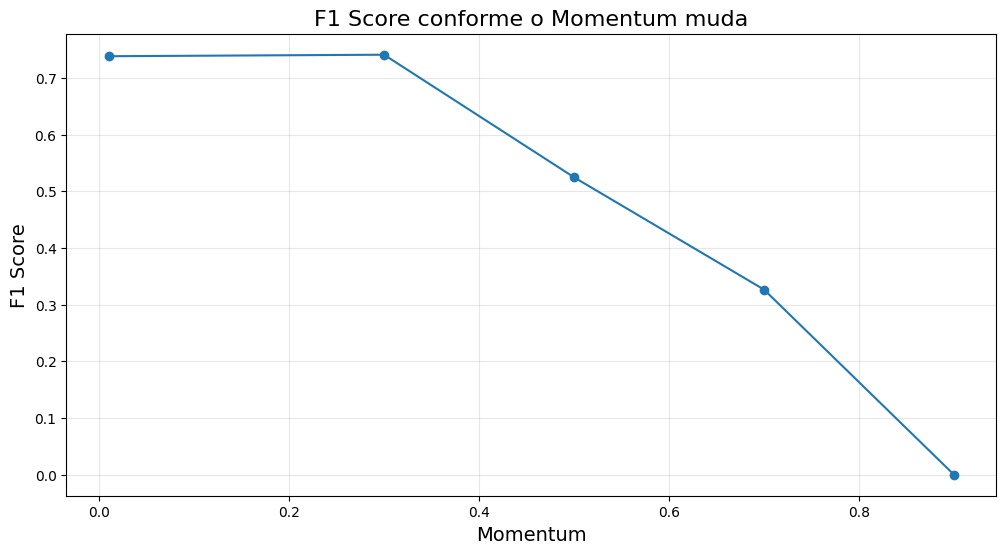

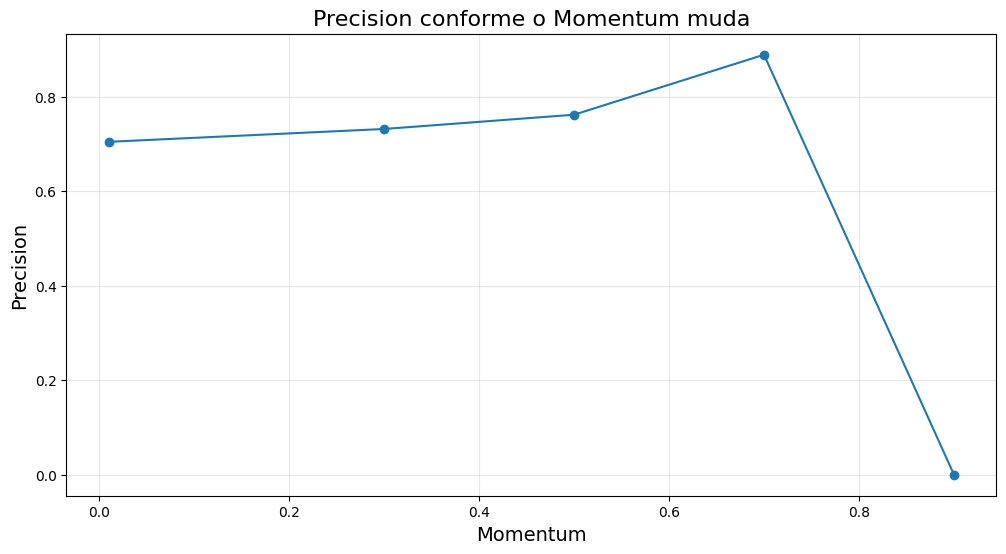

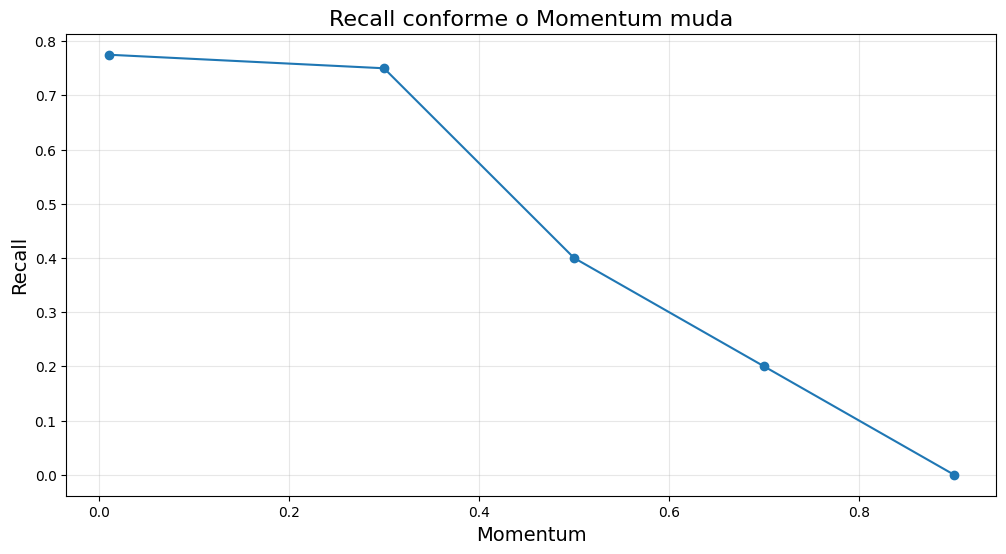

In [202]:
# Plotar as métricas de performance (Accuracy, Balanced Accuracy, F1 Score, Precision, Recall) conforme o momento diminui
metrics = ['Accuracy', 'Balanced Accuracy', 'F1 Score', 'Precision', 'Recall']

for metric in metrics:
    plt.figure(figsize=(12, 6))
    plt.plot(momentums, [result[metric] for result in results_momentum], marker='o')
    plt.title(f"{metric} conforme o Momentum muda", fontsize=16)
    plt.xlabel("Momentum", fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.grid(alpha=0.3)
    plt.show()

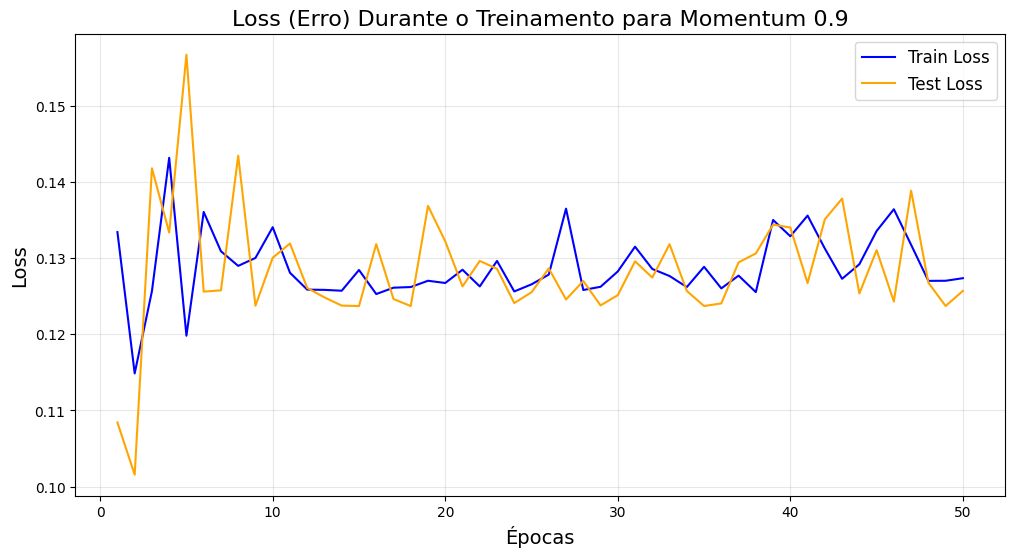

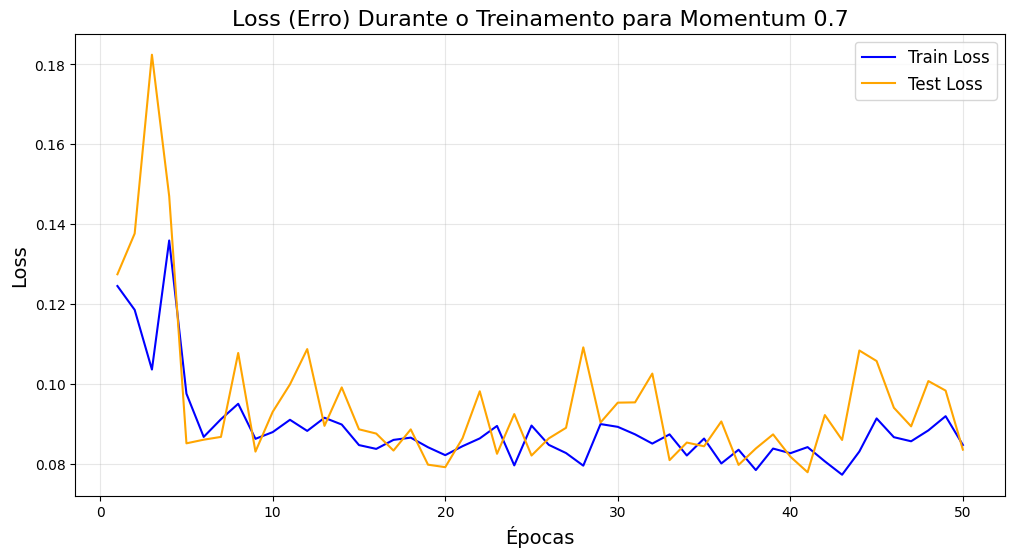

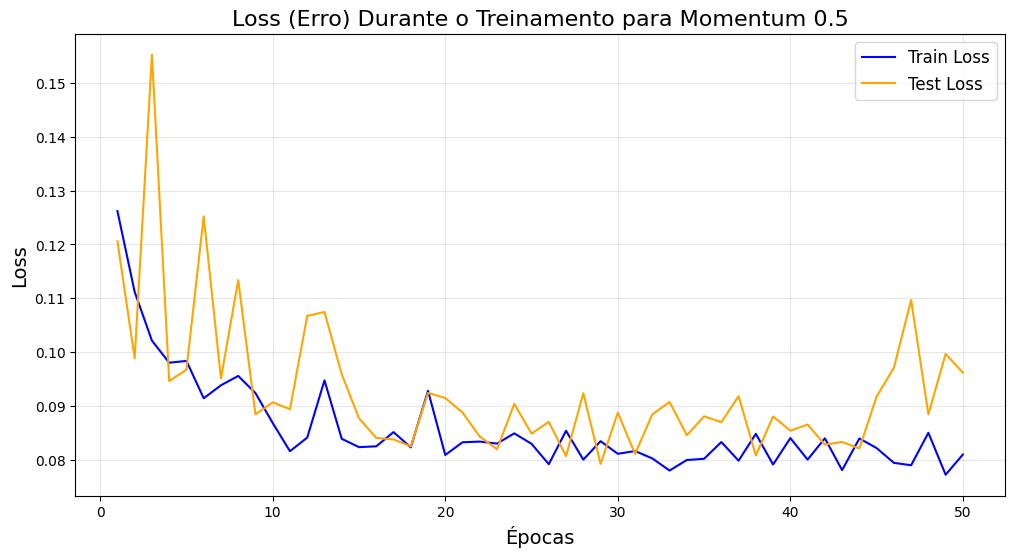

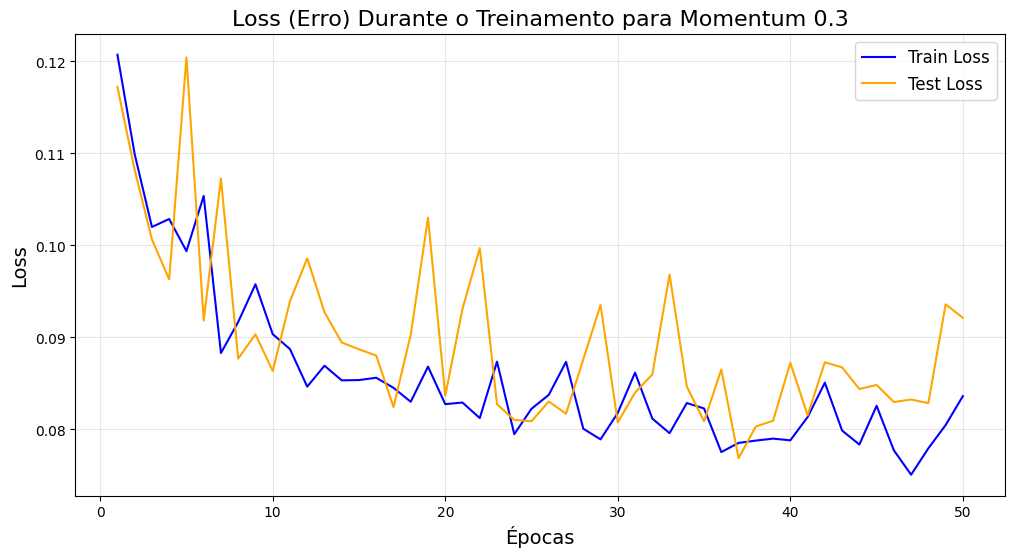

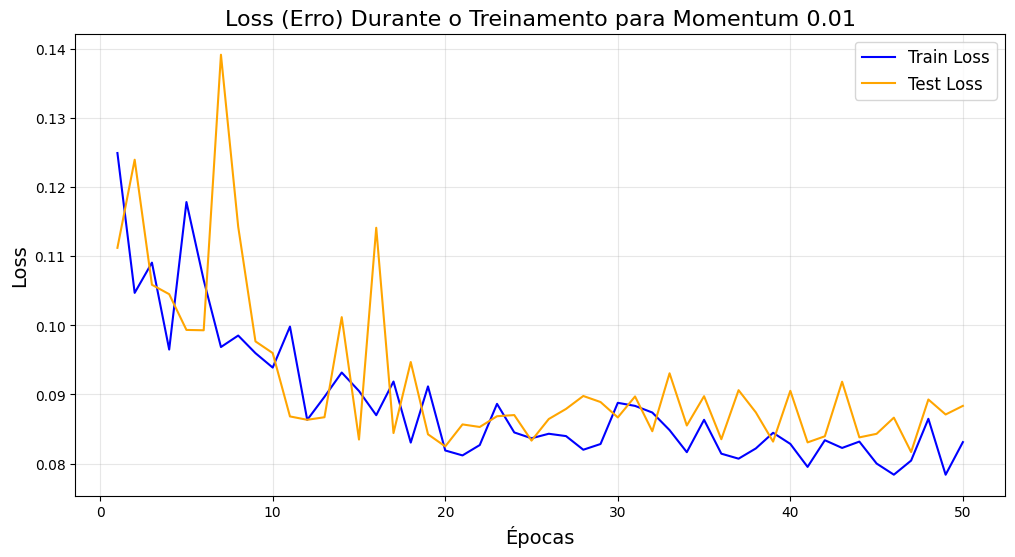

In [203]:
# Plotar a Loss de Treinamento e Teste para cada valor de Momentum
for momentum in momentums:
    mlp = MLP(10, 10, 10, 1, learning_rate=0.1, momentum=momentum)
    train_loss = []
    test_loss = []
    epochs = 50
    batch_size = 32

    for epoch in range(epochs):
        total_train_error = 0
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]

        for i in range(0, len(X_train), batch_size):
            batch_inputs = X_train[i:i + batch_size]
            batch_outputs = y_train[i:i + batch_size].reshape(-1, 1)
            mlp.forward_propagation(batch_inputs)
            mlp.backward_propagation(batch_outputs)
            total_train_error += np.sum((batch_outputs - mlp.outputs[-1]) ** 2) / 2

        avg_train_error = total_train_error / len(X_train)
        train_loss.append(avg_train_error)

        total_test_error = 0
        for i in range(0, len(X_test), batch_size):
            batch_inputs = X_test[i:i + batch_size]
            batch_outputs = y_test[i:i + batch_size].reshape(-1, 1)
            predictions = mlp.forward_propagation(batch_inputs)
            total_test_error += np.sum((batch_outputs - predictions) ** 2) / 2

        avg_test_error = total_test_error / len(X_test)
        test_loss.append(avg_test_error)

    # Plotar a loss de treino e teste para cada modelo
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 51), train_loss, label="Train Loss", color='blue')
    plt.plot(range(1, 51), test_loss, label="Test Loss", color='orange')
    plt.title(f"Loss (Erro) Durante o Treinamento para Momentum {momentum}", fontsize=16)
    plt.xlabel("Épocas", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()